In [313]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


def find_outliers(df, threshold=2):
    # Initialize a boolean mask to keep track of rows to drop
    outlier_rows_mask = np.zeros(len(df), dtype=bool)

    # Iterate over each column
    for col in df.columns:
        # Skip the "t1" and "t2" columns
        if col == "t1" or col == "t2":
            continue

        # Calculate the mean and standard deviation of the column
        mean = df[col].mean()
        std = df[col].std()

        # Find outliers in this column
        outliers = (df[col] - mean).abs() > threshold * std

        # Mark rows with outliers in this column
        outlier_rows_mask = np.logical_or(outlier_rows_mask, outliers)

    # Return the indices of the outliers
    outlier_indices = df[outlier_rows_mask].index
    return outlier_indices

In [314]:
df = pd.read_csv("../outputs/data_clean.csv")
df.set_index(pd.to_datetime(df.iloc[:, 0], format="%Y-%m-%d"), inplace=True)
df = df.drop(df.columns[0], axis=1)
df

,gpp,par,red,nir,fpar,lai,ndvi,nirv,nirvp,fesc,fesc_p,fesc_n,lue,name,type
Unnamed: 0,,,,,,,,,,,,,,,
2002-07-04,7.220345,628.195833,0.0348,0.2135,0.640000,1.700,0.719694,0.153655,96.525212,0.240085,150.820644,0.000382,0.017959,IT-SRo,ENF
2002-07-05,7.308355,615.737500,0.0378,0.2213,0.675000,2.050,0.708221,0.156729,96.504080,0.232191,142.969007,0.000377,0.017584,IT-SRo,ENF
2002-07-06,5.897100,426.125000,0.0380,0.2215,0.710000,2.400,0.707129,0.156629,66.743573,0.220604,94.005032,0.000518,0.019491,IT-SRo,ENF
2002-07-07,7.338210,587.804167,0.0381,0.2216,0.745000,2.750,0.706585,0.156579,92.037865,0.210173,123.540758,0.000358,0.016757,IT-SRo,ENF
2002-07-08,6.478290,623.954167,0.0382,0.2218,0.780000,3.100,0.706154,0.156625,97.726773,0.200801,125.290735,0.000322,0.013311,IT-SRo,ENF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-07,4.799735,204.387687,0.0264,0.2477,0.938333,4.525,0.807370,0.199985,40.874562,0.213128,43.560812,0.001043,0.025027,CA-TP4,ENF
2014-10-11,5.950615,409.667479,0.0253,0.2327,0.925000,4.125,0.803876,0.187062,76.633193,0.202229,82.846695,0.000494,0.015703,CA-TP4,ENF
2014-10-12,5.224940,409.656813,0.0251,0.2325,0.920000,4.000,0.805124,0.187191,76.684225,0.203469,83.352418,0.000497,0.013864,CA-TP4,ENF


In [315]:
ameriflux_coords = pd.read_csv("../data/Ameriflux_coords.csv")
fluxnet_coords = pd.read_csv("../data/Fluxnet_coords.csv")
merged_coords = pd.concat([ameriflux_coords, fluxnet_coords], ignore_index=True)
merged_coords.drop_duplicates(subset=merged_coords.columns[0], inplace=True)
merged_coords.reset_index(drop=True, inplace=True)
merged_coords.rename({"Name": "name"}, axis=1, inplace=True)

In [316]:
names = df["name"].unique()
types = df["type"].unique()

site_annual_max_lue = []
site_annual_max_lue_se = []
site_top_n = []
site_max_lue = []

for name in names:
    site_df = df[df["name"] == name]
    type = site_df["type"].iloc[0]
    site_df = site_df[["fpar", "nirv", "nirvp", "fesc", "lue", "lai"]]

    # Calculate the annual maximum LUE
    annual_max_lue_index = site_df.groupby(site_df.index.year)["lue"].idxmax()
    # if len(annual_max_lue_index) <3:
    #     print(name)
    #     continue
    annual_max = site_df.loc[annual_max_lue_index]
    annual_max_mean = annual_max.max()
    annual_max_mean.loc["type"] = type
    annual_max_mean.loc["name"] = name

    annual_max_std = annual_max.std()
    n = len(annual_max)
    annual_max_se = annual_max_std / np.sqrt(n)
    annual_max_se.loc["type"] = type
    annual_max_se.loc["name"] = name

    site_annual_max_lue.append(annual_max_mean)
    site_annual_max_lue_se.append(annual_max_se)

site_annual_max_lue = pd.DataFrame(site_annual_max_lue)
site_annual_max_lue_se = pd.DataFrame(site_annual_max_lue_se)
len(site_annual_max_lue)

326

In [317]:
site_annual_max_lue = pd.merge(
    site_annual_max_lue, merged_coords[["name", "Lat", "Lon"]], on="name", how="left"
)
site_annual_max_lue

,fpar,nirv,nirvp,fesc,lue,lai,type,name,Lat,Lon
0,0.810000,0.153160,51.160441,0.298672,0.203962,2.100000,ENF,IT-SRo,43.7279,10.2844
1,0.510000,0.161772,77.459487,0.341320,0.052134,1.350000,GRA,CN-HaM,37.3700,101.1800
2,0.600000,0.280287,85.906867,0.475063,0.071596,1.550000,CRO,US-ARM,36.6058,-97.4888
3,0.732500,0.377949,206.961141,0.713112,0.076431,2.200000,CRO,US-Ro1,44.7143,-93.0898
4,0.560000,0.176590,88.421102,0.327018,0.017947,1.800000,WET,AU-Fog,-12.5452,131.3072
...,...,...,...,...,...,...,...,...,...,...
321,0.701250,0.128905,28.763755,0.252291,0.054637,1.987500,ENF,CA-Obs,53.9872,-105.1178
322,0.900000,0.196169,26.155069,0.261883,0.057720,6.765000,EBF,AU-Wom,-37.4222,144.0944
323,0.910000,0.396458,137.177858,0.575752,0.052859,5.550000,DBF,US-Oho,41.5545,-83.8438
324,0.175000,0.063219,27.782834,0.409120,199.156990,0.300000,OSH,US-Jo2,32.5849,-106.6032


In [318]:
# def rename_based_on_lat(row):
#     # if row['type'] in ['ENF', 'DBF']:
#     lat = abs(row["Lat"])
#     if lat < 25:
#         suffix = "low"
#     elif lat < 55:
#         suffix = "mid"
#     else:
#         suffix = "high"

#     row["type"] = row["type"] + "_" + suffix
#     row["name"] = row["name"] + "_" + suffix
#     return row


# site_annual_max_lue = site_annual_max_lue.apply(rename_based_on_lat, axis=1)
# site_annual_max_lue

In [319]:
# names = site_annual_max_lue["name"].unique()
# types = site_annual_max_lue["type"].unique()

In [320]:
# Select the columns to find outliers in
columns_to_check = ["lue", "fesc", "fpar", "nirv", "nirvp", "lai"]
# columns_to_check = ["lue", "fesc", "fesc_p","fesc_n"]


# Create a copy of the DataFrame with only the columns to check
df_to_check = site_annual_max_lue[columns_to_check].copy()

# Use the find_outliers function to find the indices of the outliers
outlier_indices = find_outliers(df_to_check, threshold=3)

# Drop the rows with outliers from the original DataFrame
site_annual_max_lue_clean = site_annual_max_lue.drop(outlier_indices)
site_annual_max_lue = site_annual_max_lue_clean
site_annual_max_lue = site_annual_max_lue.groupby("type").filter(lambda x: len(x) >= 3)
len(site_annual_max_lue)

314

In [321]:
types = site_annual_max_lue["type"].unique()
names = site_annual_max_lue["name"].unique()
types

array(['ENF', 'GRA', 'CRO', 'WET', 'WSA', 'DBF', 'SAV', 'EBF', 'OSH',
       'CSH', 'MF'], dtype=object)

/tmp/ipykernel_2171717/1319377270.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


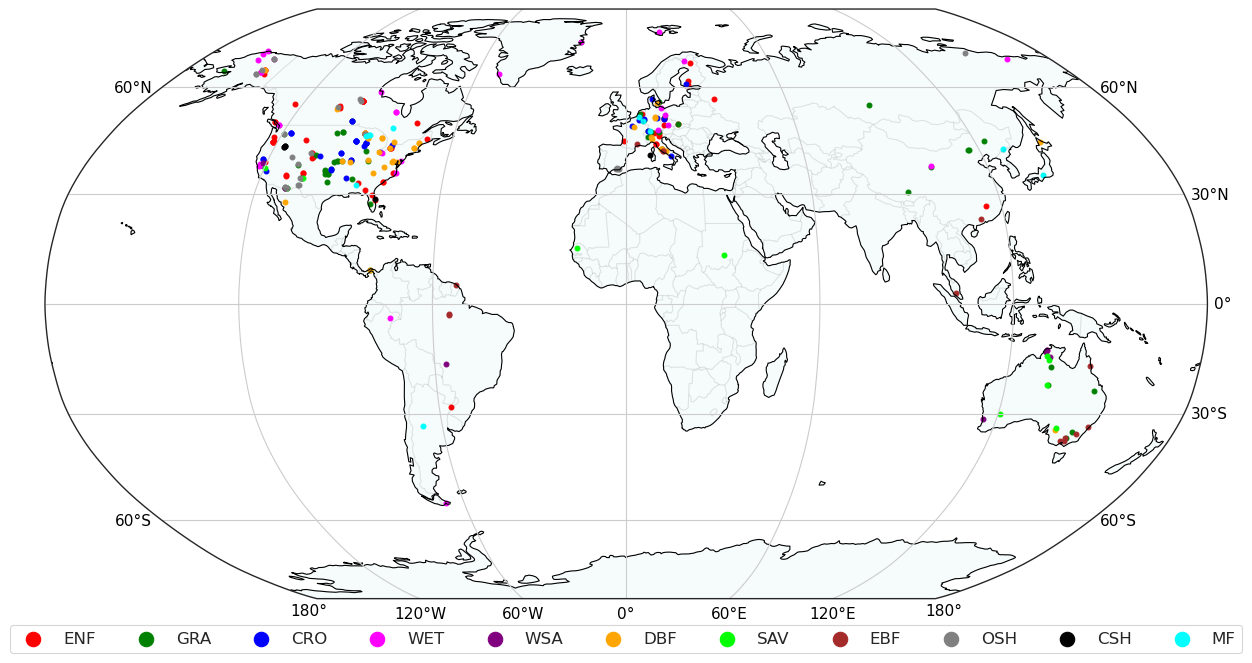

In [322]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the world boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Create a GeoDataFrame from your data
gdf = gpd.GeoDataFrame(
    site_annual_max_lue,
    geometry=gpd.points_from_xy(site_annual_max_lue.Lon, site_annual_max_lue.Lat),
)

# Define a dictionary of colors for each site type
colors = [
    "red",
    "green",
    "blue",
    "magenta",
    "purple",
    "orange",
    "lime",
    "brown",
    "gray",
    "black",
    "cyan",
]
type_color_dict = dict(zip(types, colors))

# Create a larger figure and plot the world
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(
    cfeature.LAND, color="lightblue", alpha=0.1
)  # add a faint blue color to the land
ax.coastlines()
ax.add_feature(cfeature.BORDERS, alpha=0.1)
gridlines = ax.gridlines(draw_labels=True)
gridlines.top_labels = False
gridlines.left_labels = False

gridlines.xlabel_style = {"size": 11, "color": "black"}
gridlines.ylabel_style = {"size": 11, "color": "black"}

# Plot the sites with different colors based on the type
for site_type in types:
    site_data = gdf[gdf["type"] == site_type]
    scatter = ax.scatter(
        site_data["Lon"],
        site_data["Lat"],
        color=type_color_dict[site_type],
        s=12,
        transform=ccrs.PlateCarree(),
        label=site_type,
    )

# Add a legend at the bottom
ax.legend(
    bbox_to_anchor=(0.5, -0.03), loc="upper center", ncol=11, fontsize=12, markerscale=3
)

plt.savefig("../outputs/figures/annual_max_lue_map.png", dpi=300, bbox_inches="tight")

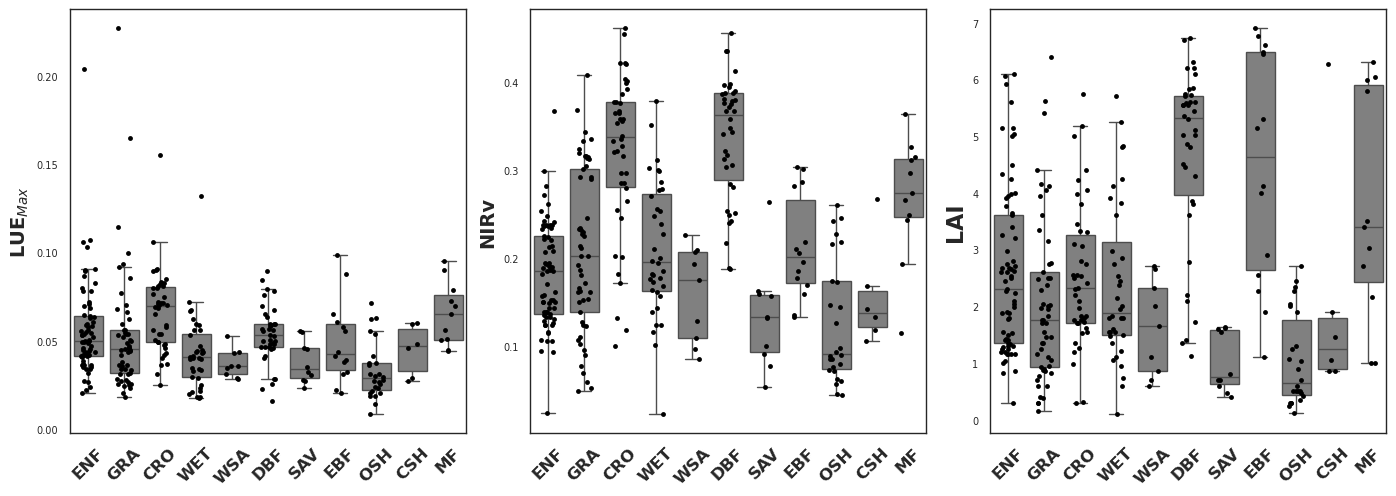

In [323]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

# Plot the boxplot of "lue" on the first subplot
sns.boxplot(
    x="type", y="lue", data=site_annual_max_lue, showfliers=False, ax=ax1, color="gray"
)
sns.stripplot(
    x="type",
    y="lue",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax1,
)
ax1.set_ylabel(r"LUE$_{Max}$", fontsize=14, weight="bold")
ax1.set_xlabel("")

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(
    x="type", y="nirv", data=site_annual_max_lue, showfliers=False, ax=ax2, color="gray"
)
sns.stripplot(
    x="type",
    y="nirv",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax2,
)
ax2.set_ylabel("NIRv", fontsize=14, weight="bold")
ax2.set_xlabel("")

# Plot the boxplot of "fesc" on the second subplot
sns.boxplot(
    x="type", y="lai", data=site_annual_max_lue, showfliers=False, ax=ax3, color="gray"
)
sns.stripplot(
    x="type",
    y="lai",
    data=site_annual_max_lue,
    color="black",
    jitter=0.2,
    size=3.5,
    ax=ax3,
)
ax3.set_ylabel("LAI", fontsize=16, weight="bold")
ax3.set_xlabel("")

for label in ax1.get_xticklabels():
    label.set_weight("bold")
for label in ax2.get_xticklabels():
    label.set_weight("bold")
for label in ax3.get_xticklabels():
    label.set_weight("bold")

ax1.tick_params(axis="x", rotation=45, labelsize=12)
ax2.tick_params(axis="x", rotation=45, labelsize=12)
ax3.tick_params(axis="x", rotation=45, labelsize=12)
plt.tight_layout()
plt.savefig(
    "../outputs/figures/annual_max_lue_boxplot.png", dpi=300, bbox_inches="tight"
)

In [324]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)
]
site_annual_max_lue_grouped_mean = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai"]]
    .groupby("type")
    .median()
)
site_annual_max_lue_grouped_std = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai"]]
    .groupby("type")
    .std()
)
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(np.sqrt(n), axis=0)

In [340]:
site_annual_max_lue_grouped_mean

,fpar,nirv,nirvp,fesc,lue,lai,dlue_dlai,dnirv_dlai
type,,,,,,,,
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125,0.021270,0.187720
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500,0.028239,0.234464
DBF,0.901250,0.362982,98.551784,0.506816,0.053090,5.3250,0.018377,0.272183
EBF,0.868125,0.201026,46.852877,0.320755,0.042413,4.6375,0.011270,0.183541
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000,0.006280,-0.024082
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500,0.006753,-0.068589
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000,0.010213,0.008717
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500,0.052788,0.425740
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500,0.047695,0.383805


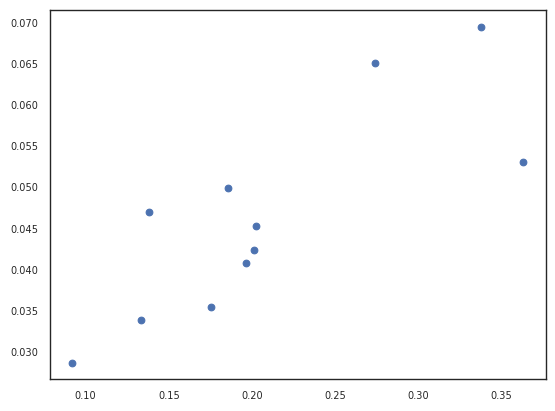

In [339]:
plt.scatter(
    site_annual_max_lue_grouped_mean["nirv"], site_annual_max_lue_grouped_mean["lue"]
)

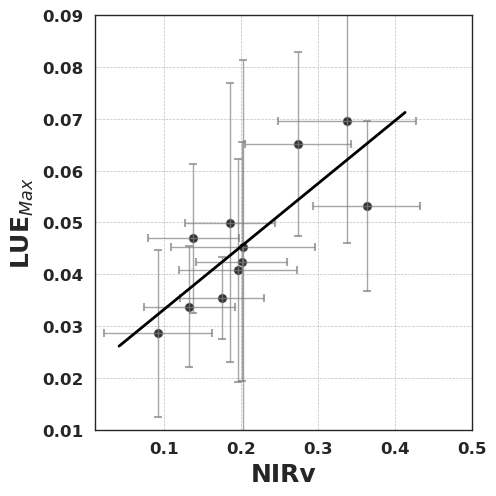

y = 0.121434 x + 0.021074
R-squared: 0.659900


<Figure size 640x480 with 0 Axes>

In [326]:
plt.figure(figsize=(5, 5))

# Extract standard errors for lue and nirv
lue_se = site_annual_max_lue_grouped_std["lue"]
nirv_se = site_annual_max_lue_grouped_std["nirv"]

# Create error bars
(_, caps, _) = plt.errorbar(
    x=site_annual_max_lue_grouped_mean["nirv"],
    y=site_annual_max_lue_grouped_mean["lue"],
    xerr=nirv_se,
    yerr=lue_se,
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    site_annual_max_lue_grouped_mean["nirv"],
    site_annual_max_lue_grouped_mean["lue"],
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Fit a line to the data
z = np.polyfit(
    site_annual_max_lue_grouped_mean["nirv"], site_annual_max_lue_grouped_mean["lue"], 1
)

# Create a function from the fit parameters
p = np.poly1d(z)

# Calculate the minimum and maximum x-values considering the standard deviation
x_min = site_annual_max_lue_grouped_mean["nirv"].min() - 0.05
x_max = site_annual_max_lue_grouped_mean["nirv"].max() + 0.05

# Add the regression line to the plot
plt.plot([x_min, x_max], p([x_min, x_max]), color="black", linewidth=2)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xlabel(
    "NIRv", fontsize=18, weight="bold"
)  # Set the font size and weight of the x-axis label
plt.ylabel(
    "LUE$_{Max}$", fontsize=18, weight="bold"
)  # Set the font size and weight of the y-axis label
plt.xticks(
    fontsize=12, weight="bold"
)  # Set the font size and weight of the x-axis tick labels
plt.yticks(
    fontsize=12, weight="bold"
)  # Set the font size and weight of the y-axis tick labels
plt.xlim(0.01, 0.5)
plt.ylim(0.01, 0.09)
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

# Print the equation and R-squared value
print("y = %.6f x + %.6f" % (z[0], z[1]))
print(
    "R-squared: %.6f"
    % r2_score(
        site_annual_max_lue_grouped_mean["lue"],
        p(site_annual_max_lue_grouped_mean["nirv"]),
    )
)
plt.savefig("../outputs/figures/lue_nirv_regression.png", dpi=300, bbox_inches="tight")

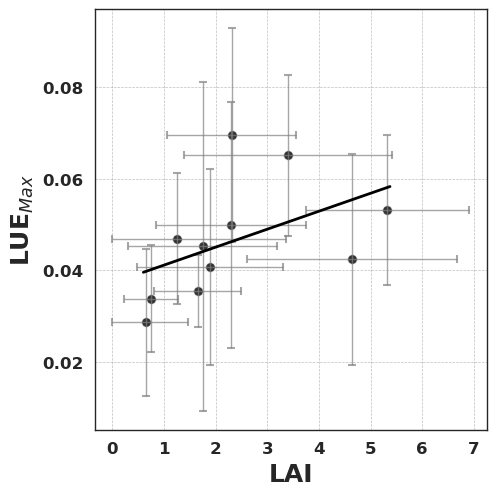

y = 0.003930 x + 0.037194
R-squared: 0.223313


<Figure size 640x480 with 0 Axes>

In [334]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

# Extract standard errors for lue and lai
lue_se = site_annual_max_lue_grouped_std["lue"]
lai_se = site_annual_max_lue_grouped_std["lai"]

# Calculate the upper and lower limits for the error bars, ensuring no negative values
lue_upper = site_annual_max_lue_grouped_mean["lue"] + lue_se
lue_lower = np.maximum(site_annual_max_lue_grouped_mean["lue"] - lue_se, 0)

lai_upper = site_annual_max_lue_grouped_mean["lai"] + lai_se
lai_lower = np.maximum(site_annual_max_lue_grouped_mean["lai"] - lai_se, 0)

# Create error bars with the adjusted limits
(_, caps, _) = plt.errorbar(
    x=site_annual_max_lue_grouped_mean["lai"],
    y=site_annual_max_lue_grouped_mean["lue"],
    xerr=[
        site_annual_max_lue_grouped_mean["lai"] - lai_lower,
        lai_upper - site_annual_max_lue_grouped_mean["lai"],
    ],
    yerr=[
        site_annual_max_lue_grouped_mean["lue"] - lue_lower,
        lue_upper - site_annual_max_lue_grouped_mean["lue"],
    ],
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    site_annual_max_lue_grouped_mean["lai"],
    site_annual_max_lue_grouped_mean["lue"],
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Fit a line to the data
z = np.polyfit(
    site_annual_max_lue_grouped_mean["lai"], site_annual_max_lue_grouped_mean["lue"], 1
)

# Create a function from the fit parameters
p = np.poly1d(z)

# Calculate the minimum and maximum x-values considering the standard deviation
x_min = site_annual_max_lue_grouped_mean["lai"].min() - 0.05
x_max = site_annual_max_lue_grouped_mean["lai"].max() + 0.05

# Add the regression line to the plot
plt.plot([x_min, x_max], p([x_min, x_max]), color="black", linewidth=2)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xlabel(
    "LAI", fontsize=18, weight="bold"
)  # Set the font size and weight of the x-axis label
plt.ylabel(
    "LUE$_{Max}$", fontsize=18, weight="bold"
)  # Set the font size and weight of the y-axis label
plt.xticks(
    fontsize=12, weight="bold"
)  # Set the font size and weight of the x-axis tick labels
plt.yticks(
    fontsize=12, weight="bold"
)  # Set the font size and weight of the y-axis tick labels

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

# Print the equation and R-squared value
print("y = %.6f x + %.6f" % (z[0], z[1]))
print(
    "R-squared: %.6f"
    % r2_score(
        site_annual_max_lue_grouped_mean["lue"],
        p(site_annual_max_lue_grouped_mean["lai"]),
    )
)
plt.savefig("../outputs/figures/lue_lai_regression.png", dpi=300, bbox_inches="tight")

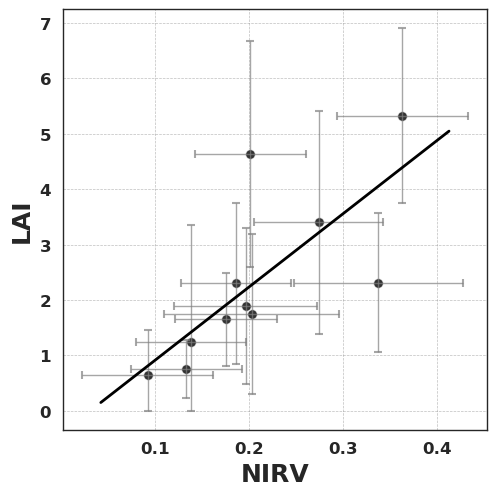

y = 13.201362 x + -0.403181
R-squared: 0.539369


<Figure size 640x480 with 0 Axes>

In [328]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))

# Extract standard errors for nirv and lai
nirv_se = site_annual_max_lue_grouped_std["nirv"]
lai_se = site_annual_max_lue_grouped_std["lai"]

# Calculate the upper and lower limits for the error bars, ensuring no negative values
nirv_upper = site_annual_max_lue_grouped_mean["nirv"] + nirv_se
nirv_lower = np.maximum(site_annual_max_lue_grouped_mean["nirv"] - nirv_se, 0)

lai_upper = site_annual_max_lue_grouped_mean["lai"] + lai_se
lai_lower = np.maximum(site_annual_max_lue_grouped_mean["lai"] - lai_se, 0)

# Create error bars with the adjusted limits
(_, caps, _) = plt.errorbar(
    x=site_annual_max_lue_grouped_mean["nirv"],
    y=site_annual_max_lue_grouped_mean["lai"],
    xerr=[
        site_annual_max_lue_grouped_mean["nirv"] - nirv_lower,
        nirv_upper - site_annual_max_lue_grouped_mean["nirv"],
    ],
    yerr=[
        site_annual_max_lue_grouped_mean["lai"] - lai_lower,
        lai_upper - site_annual_max_lue_grouped_mean["lai"],
    ],
    fmt="none",
    ecolor="gray",
    elinewidth=1,
    capsize=3,
    alpha=0.7,
)

# Set the cap size of the error bars
for cap in caps:
    cap.set_markeredgewidth(1.5)

# Add black bullets
plt.scatter(
    site_annual_max_lue_grouped_mean["nirv"],
    site_annual_max_lue_grouped_mean["lai"],
    color="black",
    alpha=0.8,
    edgecolor="white",
    s=50,
)

# Fit a line to the data
z = np.polyfit(
    site_annual_max_lue_grouped_mean["nirv"], site_annual_max_lue_grouped_mean["lai"], 1
)

# Create a function from the fit parameters
p = np.poly1d(z)

# Calculate the minimum and maximum x-values considering the standard deviation
x_min = site_annual_max_lue_grouped_mean["nirv"].min() - 0.05
x_max = site_annual_max_lue_grouped_mean["nirv"].max() + 0.05

# Add the regression line to the plot
plt.plot([x_min, x_max], p([x_min, x_max]), color="black", linewidth=2)

# Get the current axes
ax = plt.gca()

# Add gridlines for better readability
ax.grid(True, which="both", linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xlabel(
    "NIRV", fontsize=18, weight="bold"
)  # Set the font size and weight of the x-axis label
plt.ylabel(
    "LAI", fontsize=18, weight="bold"
)  # Set the font size and weight of the y-axis label
plt.xticks(
    fontsize=12, weight="bold"
)  # Set the font size and weight of the x-axis tick labels
plt.yticks(
    fontsize=12, weight="bold"
)  # Set the font size and weight of the y-axis tick labels

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

# Print the equation and R-squared value
print("y = %.6f x + %.6f" % (z[0], z[1]))
print(
    "R-squared: %.6f"
    % r2_score(
        site_annual_max_lue_grouped_mean["lai"],
        p(site_annual_max_lue_grouped_mean["nirv"]),
    )
)
plt.savefig("../outputs/figures/lai_nirv_regression.png", dpi=300, bbox_inches="tight")

In [453]:
site_annual_max_lue_grouped_mean

,fpar,nirv,nirvp,fesc,lue,lai,dlue_dlai,dnirv_dlai
type,,,,,,,,
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125,0.021270,0.187720
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500,0.028239,0.234464
DBF,0.901250,0.362982,98.551784,0.506816,0.053090,5.3250,0.018377,0.272183
EBF,0.868125,0.201026,46.852877,0.320755,0.042413,4.6375,0.011270,0.183541
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000,0.006280,-0.024082
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500,0.006753,-0.068589
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000,0.010213,0.008717
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500,0.052788,0.425740
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500,0.047695,0.383805


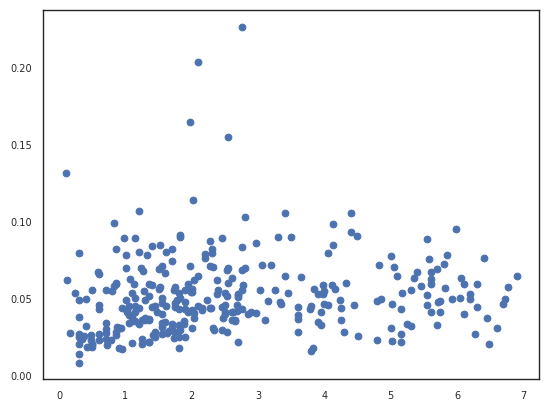

In [411]:
plt.scatter(site_annual_max_lue["lai"], site_annual_max_lue["lue"])

/tmp/ipykernel_2171717/531862030.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (site_annual_max_lue_grouped_mean["lai"][i], site_annual_max_lue_grouped_mean["lue"][i]))


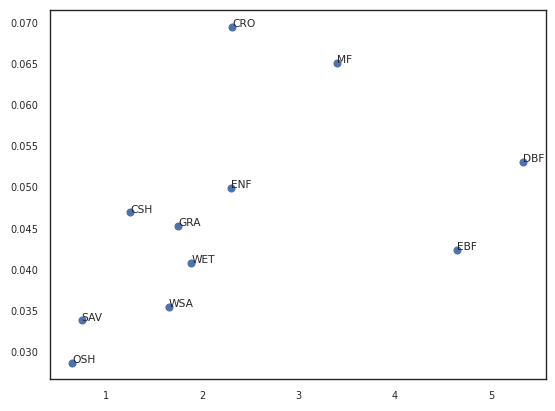

In [397]:
plt.plot(
    site_annual_max_lue_grouped_mean["lai"],
    site_annual_max_lue_grouped_mean["lue"],
    "o",
)
for i, txt in enumerate(site_annual_max_lue_grouped_mean.index):
    plt.annotate(
        txt,
        (
            site_annual_max_lue_grouped_mean["lai"][i],
            site_annual_max_lue_grouped_mean["lue"][i],
        ),
    )

In [399]:
tmp = site_annual_max_lue_grouped_mean.sort_values("lai")
tmp

,fpar,nirv,nirvp,fesc,lue,lai,dlue_dlai,dnirv_dlai
type,,,,,,,,
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500,0.052788,0.425740
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500,0.047695,0.383805
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500,0.028239,0.234464
WSA,0.510000,0.175598,56.961575,0.349729,0.035480,1.6500,0.022225,0.086871
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500,0.006753,-0.068589
WET,0.655000,0.196230,45.559644,0.379135,0.040759,1.8875,0.026475,0.095154
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000,0.006280,-0.024082
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125,0.021270,0.187720
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000,0.010213,0.008717


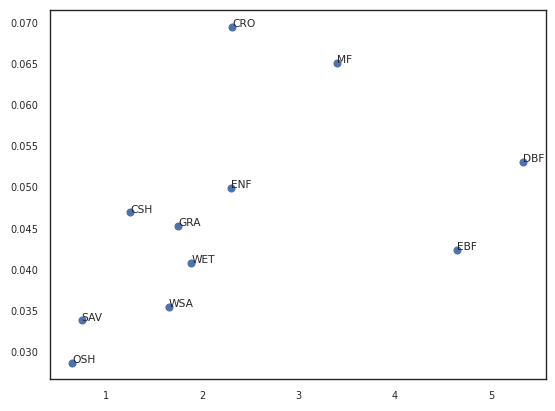

In [336]:
tmp = site_annual_max_lue_grouped_mean.sort_values(by="lai")

plt.plot(tmp["lai"], tmp["lue"], "o")
for i, txt in enumerate(tmp.index):
    plt.annotate(txt, (tmp["lai"].iloc[i], tmp["lue"].iloc[i]))

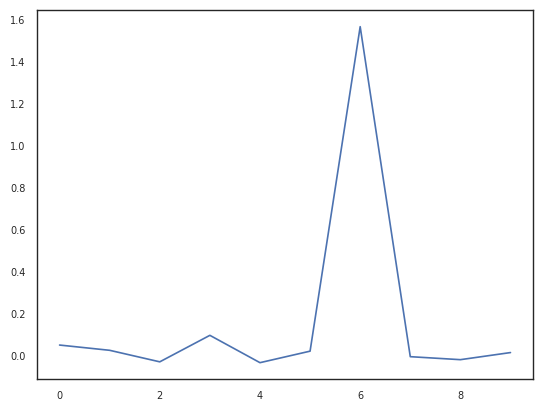

In [403]:
lai_sorted = tmp["lai"]
lue_sorted = tmp["lue"]
types_sorted = tmp.index
delta_lai_sorted = np.diff(lai_sorted)
delta_lue_sorted = np.diff(lue_sorted)
plt.plot(delta_lue_sorted / delta_lai_sorted)

In [406]:
import numpy as np
import matplotlib.pyplot as plt

# Provided data
lai = np.array(
    [
        2.31250005,
        1.25000003,
        5.32500017,
        4.63750005,
        2.3,
        1.75,
        3.4000001,
        0.65,
        0.75,
        1.88750005,
        1.65,
    ]
)
lue = np.array(
    [
        0.06953986,
        0.04694091,
        0.05309044,
        0.04241284,
        0.04993007,
        0.04524734,
        0.0651081,
        0.02866226,
        0.03379728,
        0.0407587,
        0.03548034,
    ]
)
plant_types = np.array(
    ["ENF", "GRA", "CRO", "WET", "WSA", "DBF", "SAV", "EBF", "OSH", "CSH", "MF"],
    dtype=object,
)
sorted_indices = np.argsort(lai)
lai_sorted = lai[sorted_indices]
lue_sorted = lue[sorted_indices]
plant_types_sorted = plant_types[sorted_indices]
# Compute finite differences for sorted data
delta_lai_sorted = np.diff(lai_sorted)
delta_lue_sorted = np.diff(lue_sorted)

# Calculate sensitivity for sorted data
sensitivity_sorted = delta_lue_sorted / delta_lai_sorted

# Calculate midpoints for plotting sensitivity
midpoints_lai_sorted = (lai_sorted[:-1] + lai_sorted[1:]) / 2

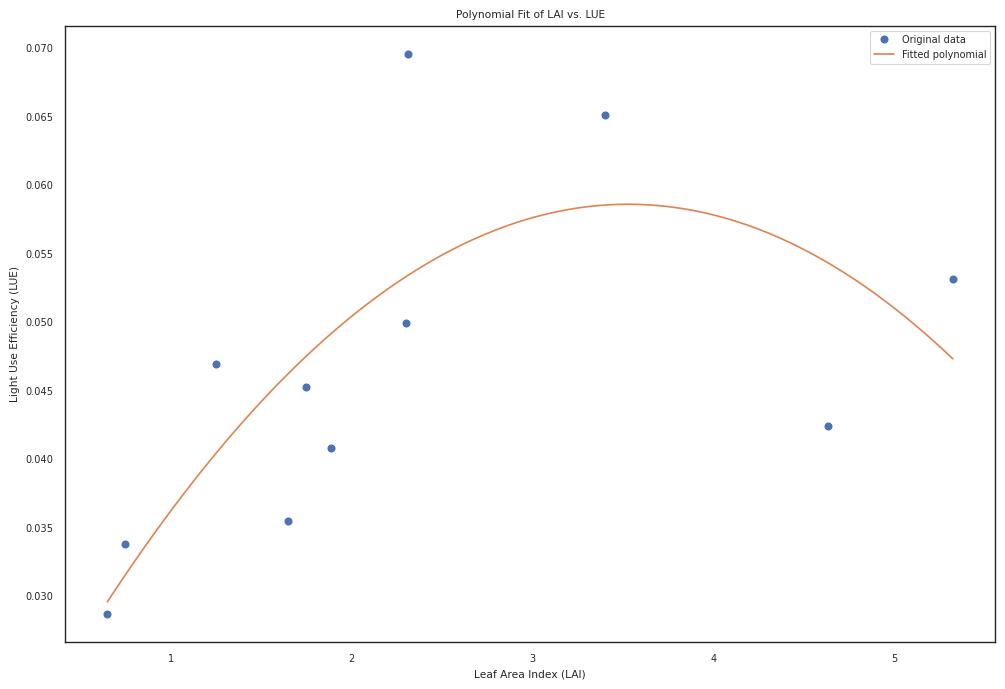

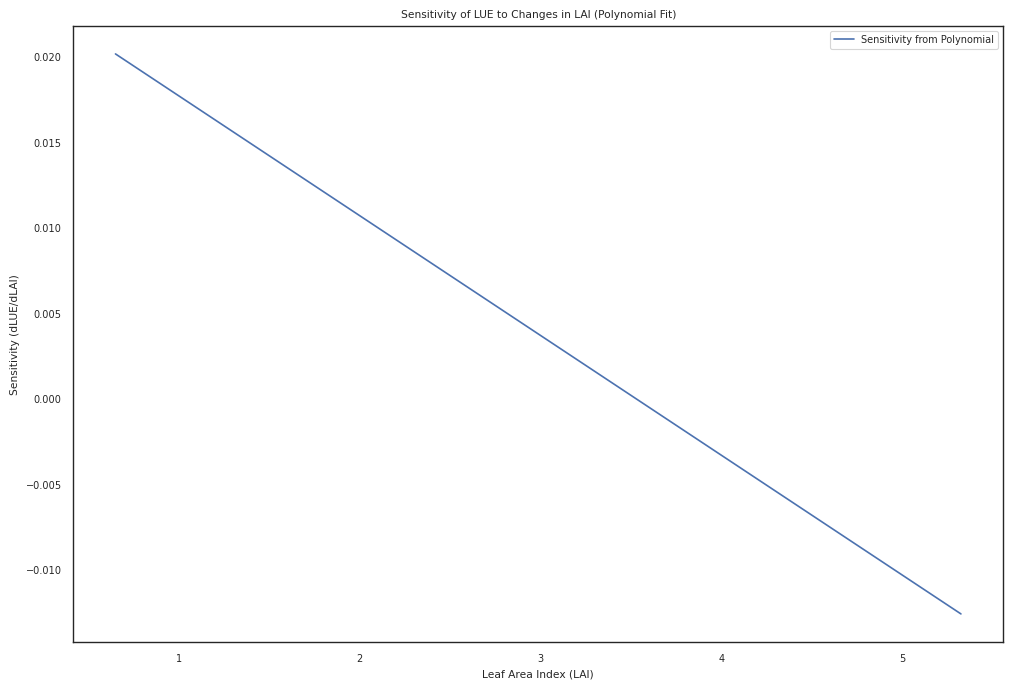

In [413]:
# Fit a polynomial of degree 2 (quadratic) to the sorted data
coefficients = np.polyfit(lai_sorted, lue_sorted, 2)
polynomial = np.poly1d(coefficients)

# Calculate the derivative of the polynomial
derivative = np.polyder(polynomial)

# Generate fitted values and their derivative
lai_fit = np.linspace(min(lai_sorted), max(lai_sorted), 100)
lue_fit = polynomial(lai_fit)
sensitivity_fit = derivative(lai_fit)

# Plot LAI vs. LUE with the polynomial fit
plt.figure(figsize=(12, 8))
plt.plot(lai_sorted, lue_sorted, "o", label="Original data")
plt.plot(lai_fit, lue_fit, "-", label="Fitted polynomial")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Light Use Efficiency (LUE)")
plt.title("Polynomial Fit of LAI vs. LUE")
plt.legend()
plt.show()

# Plot sensitivity derived from the polynomial
plt.figure(figsize=(12, 8))
plt.plot(lai_fit, sensitivity_fit, "-", label="Sensitivity from Polynomial")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Sensitivity (dLUE/dLAI)")
plt.title("Sensitivity of LUE to Changes in LAI (Polynomial Fit)")
plt.legend()
plt.show()

In [417]:
# Provided data
lai = np.array(
    [
        2.31250005,
        1.25000003,
        5.32500017,
        4.63750005,
        2.3,
        1.75,
        3.4000001,
        0.65,
        0.75,
        1.88750005,
        1.65,
    ]
)
lue = np.array(
    [
        0.06953986,
        0.04694091,
        0.05309044,
        0.04241284,
        0.04993007,
        0.04524734,
        0.0651081,
        0.02866226,
        0.03379728,
        0.0407587,
        0.03548034,
    ]
)
plant_types = np.array(
    ["ENF", "GRA", "CRO", "WET", "WSA", "DBF", "SAV", "EBF", "OSH", "CSH", "MF"],
    dtype=object,
)

In [422]:
site_annual_max_lue_grouped_mean.index

Index(['CRO', 'CSH', 'DBF', 'EBF', 'ENF', 'GRA', 'MF', 'OSH', 'SAV', 'WET',
       'WSA'],
      dtype='object', name='type')

In [420]:
tmp.index

Index(['OSH', 'SAV', 'CSH', 'WSA', 'GRA', 'WET', 'ENF', 'CRO', 'MF', 'EBF',
       'DBF'],
      dtype='object', name='type')

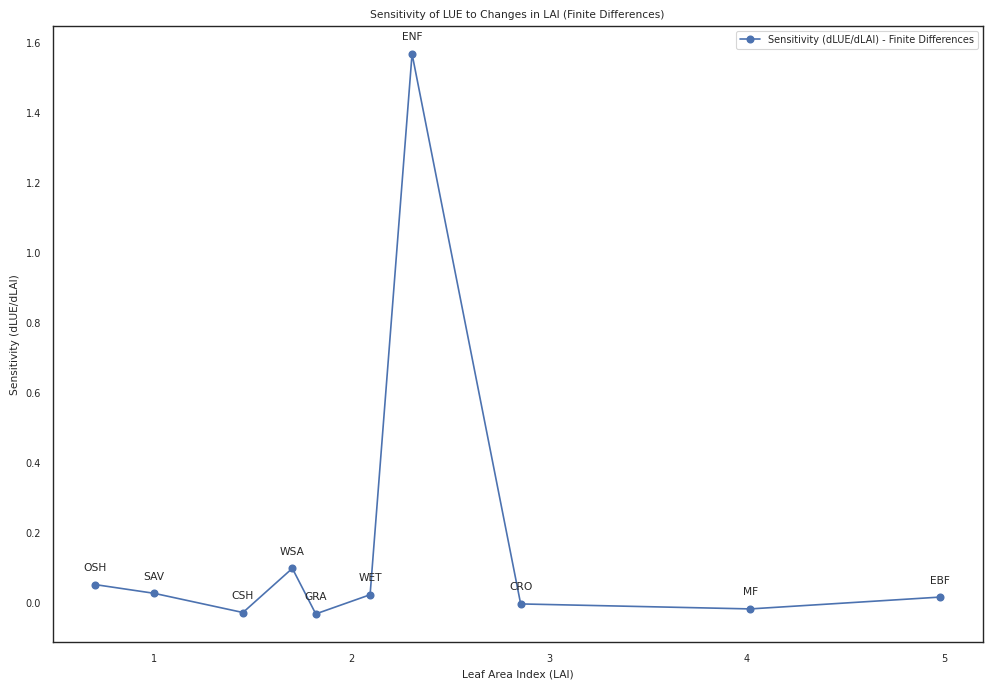

In [448]:
import numpy as np
import matplotlib.pyplot as plt

# Provided data
lai = np.array(
    [
        2.31250005,
        1.25000003,
        5.32500017,
        4.63750005,
        2.3,
        1.75,
        3.4000001,
        0.65,
        0.75,
        1.88750005,
        1.65,
    ]
)
lue = np.array(
    [
        0.06953986,
        0.04694091,
        0.05309044,
        0.04241284,
        0.04993007,
        0.04524734,
        0.0651081,
        0.02866226,
        0.03379728,
        0.0407587,
        0.03548034,
    ]
)
plant_types = np.array(
    ["CRO", "CSH", "DBF", "EBF", "ENF", "GRA", "MF", "OSH", "SAV", "WET", "WSA"],
    dtype=object,
)
sorted_indices = np.argsort(lai)
lai_sorted = lai[sorted_indices]
lue_sorted = lue[sorted_indices]
plant_types_sorted = plant_types[sorted_indices]
delta_lai_sorted = np.diff(lai_sorted)
delta_lue_sorted = np.diff(lue_sorted)

# Calculate sensitivity for sorted data
sensitivity_sorted = delta_lue_sorted / delta_lai_sorted

# Calculate midpoints for plotting sensitivity
midpoints_lai_sorted = (lai_sorted[:-1] + lai_sorted[1:]) / 2
plt.figure(figsize=(12, 8))
plt.plot(
    midpoints_lai_sorted,
    sensitivity_sorted,
    "-o",
    label="Sensitivity (dLUE/dLAI) - Finite Differences",
)
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Sensitivity (dLUE/dLAI)")
plt.title("Sensitivity of LUE to Changes in LAI (Finite Differences)")
plt.legend()

# Annotate points with plant types
for i in range(len(midpoints_lai_sorted)):
    plt.annotate(
        plant_types_sorted[i],
        (midpoints_lai_sorted[i], sensitivity_sorted[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

plt.show()

Index(['OSH', 'SAV', 'CSH', 'WSA', 'GRA', 'WET', 'ENF', 'CRO', 'MF', 'EBF',
       'DBF'],
      dtype='object', name='type')

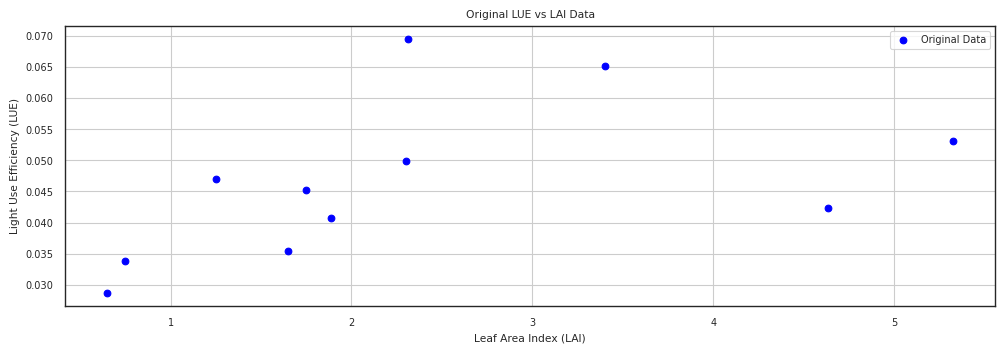

In [449]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

lai = np.array(
    [
        2.31250005,
        1.25000003,
        5.32500017,
        4.63750005,
        2.3,
        1.75,
        3.4000001,
        0.65,
        0.75,
        1.88750005,
        1.65,
    ]
)
lue = np.array(
    [
        0.06953986,
        0.04694091,
        0.05309044,
        0.04241284,
        0.04993007,
        0.04524734,
        0.0651081,
        0.02866226,
        0.03379728,
        0.0407587,
        0.03548034,
    ]
)

# Sort the data
sort_idx = np.argsort(lai)
lai_sorted = lai[sort_idx]
lue_sorted = lue[sort_idx]

# Calculate the derivative
derivative = np.diff(lue_sorted) / np.diff(lai_sorted)

# Calculate midpoints for plotting the derivative
lai_mid = (lai_sorted[1:] + lai_sorted[:-1]) / 2

# Plot original data
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.scatter(lai, lue, color="blue", label="Original Data")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Light Use Efficiency (LUE)")
plt.title("Original LUE vs LAI Data")
plt.legend()
plt.grid(True)

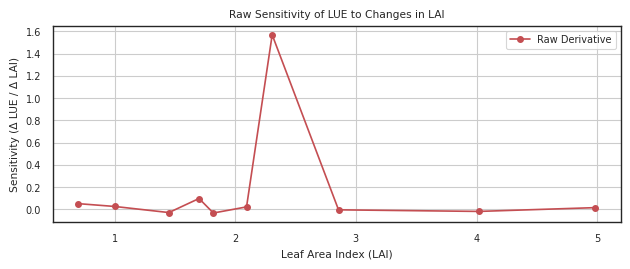

In [450]:
# Plot the raw derivative
plt.subplot(2, 1, 2)
plt.plot(lai_mid, derivative, "ro-", markersize=4, label="Raw Derivative")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Sensitivity (Δ LUE / Δ LAI)")
plt.title("Raw Sensitivity of LUE to Changes in LAI")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

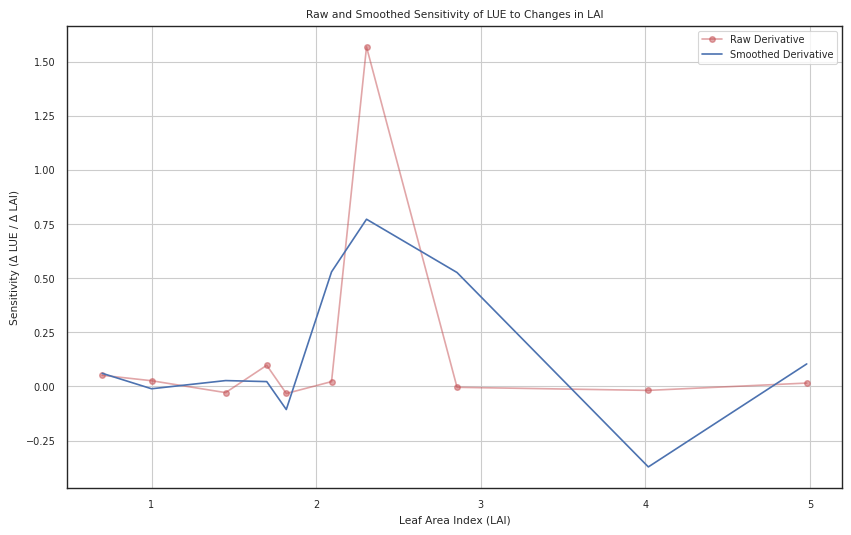

In [451]:
# Smooth the derivative if possible
if len(derivative) >= 5:
    window_length = min(len(derivative) - 2, 5)  # must be odd and less than data length
    poly_order = min(window_length - 1, 3)  # must be less than window_length
    derivative_smooth = savgol_filter(derivative, window_length, poly_order)

    # Plot both raw and smoothed derivatives
    plt.figure(figsize=(10, 6))
    plt.plot(
        lai_mid, derivative, "ro-", markersize=4, alpha=0.5, label="Raw Derivative"
    )
    plt.plot(lai_mid, derivative_smooth, "b-", label="Smoothed Derivative")
    plt.xlabel("Leaf Area Index (LAI)")
    plt.ylabel("Sensitivity (Δ LUE / Δ LAI)")
    plt.title("Raw and Smoothed Sensitivity of LUE to Changes in LAI")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough data points for smoothing. Showing only raw derivative.")

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

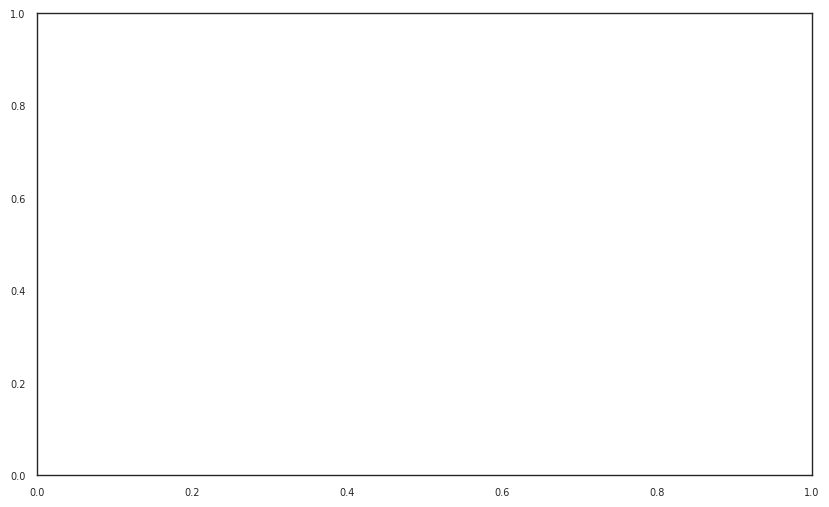

In [444]:
lai = tmp["lai"]
lue = tmp["lue"]
import numpy as np
import matplotlib.pyplot as plt

# Assuming lai and lue are your sorted data arrays
derivative = np.diff(lue) / np.diff(lai)
lai_mid = (lai[1:] + lai[:-1]) / 2

plt.figure(figsize=(10, 6))
plt.plot(lai_mid, derivative, "-o", markersize=4)
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Sensitivity (Δ LUE / Δ LAI)")
plt.title("Sensitivity of LUE to Changes in LAI (Actual Data)")
plt.grid(True)
plt.show()

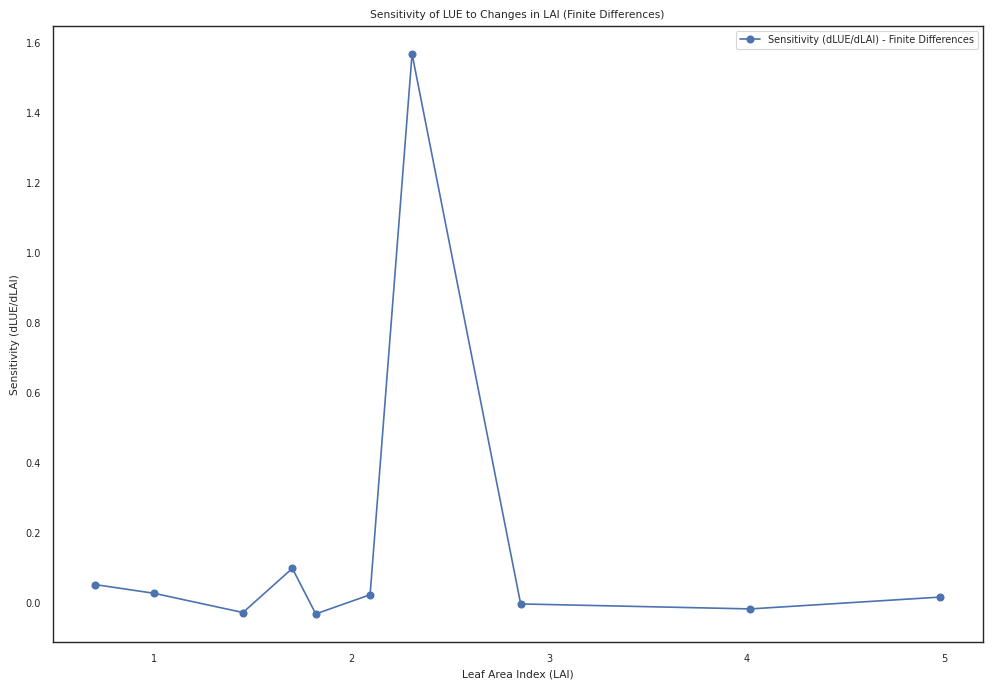

In [408]:
plt.figure(figsize=(12, 8))
plt.plot(
    midpoints_lai_sorted,
    sensitivity_sorted,
    "-o",
    label="Sensitivity (dLUE/dLAI) - Finite Differences",
)
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Sensitivity (dLUE/dLAI)")
plt.title("Sensitivity of LUE to Changes in LAI (Finite Differences)")
plt.legend()
plt.show()

In [416]:
plant_types_sorted

array(['EBF', 'OSH', 'GRA', 'MF', 'DBF', 'CSH', 'WSA', 'ENF', 'SAV',
       'WET', 'CRO'], dtype=object)

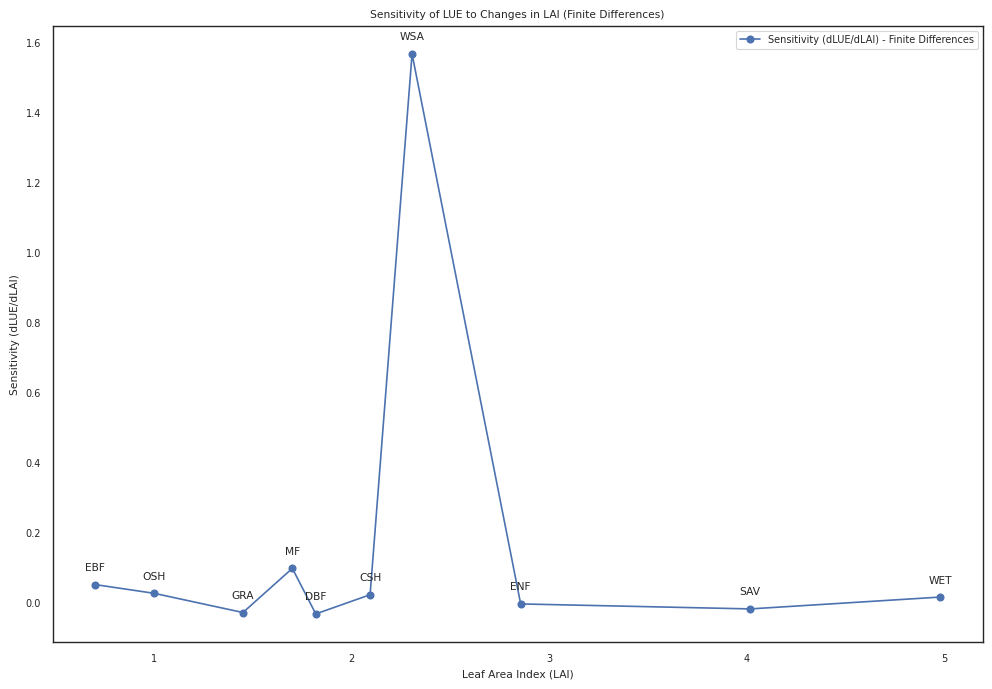

In [415]:
plt.figure(figsize=(12, 8))
plt.plot(
    midpoints_lai_sorted,
    sensitivity_sorted,
    "-o",
    label="Sensitivity (dLUE/dLAI) - Finite Differences",
)
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Sensitivity (dLUE/dLAI)")
plt.title("Sensitivity of LUE to Changes in LAI (Finite Differences)")
plt.legend()

# Annotate points with indices
for i in range(len(midpoints_lai_sorted)):
    plt.annotate(
        plant_types_sorted[i],
        (midpoints_lai_sorted[i], sensitivity_sorted[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

plt.show()

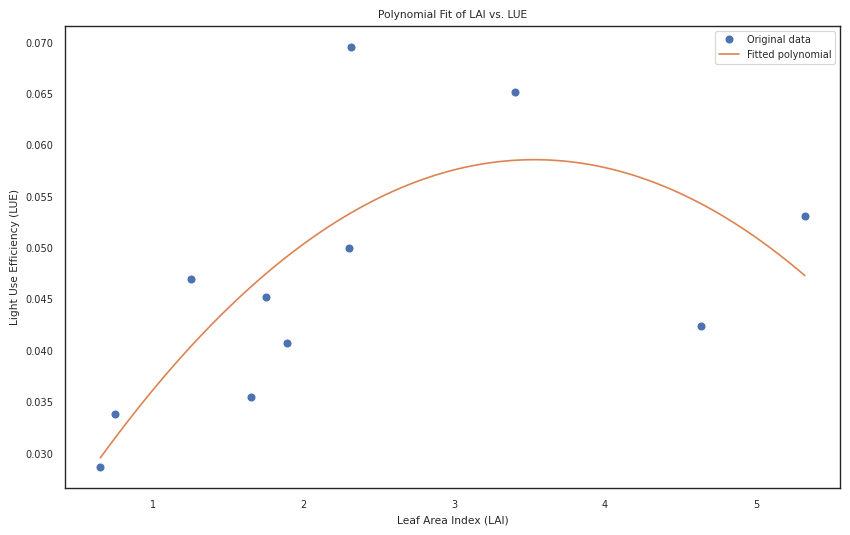

In [350]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.stats import gaussian_kde

# Assuming you have your data in two lists or numpy arrays: lai and lue
lai = site_annual_max_lue_grouped_mean["lai"].values
lue = site_annual_max_lue_grouped_mean["lue"].values
# Polynomial fit of degree 2 (quadratic)
coefficients = np.polyfit(lai, lue, 2)
polynomial = np.poly1d(coefficients)

# Generate fitted values
lai_fit = np.linspace(min(lai), max(lai), 100)
lue_fit = polynomial(lai_fit)

plt.figure(figsize=(10, 6))
plt.plot(lai, lue, "o", label="Original data")
plt.plot(lai_fit, lue_fit, "-", label="Fitted polynomial")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Light Use Efficiency (LUE)")
plt.title("Polynomial Fit of LAI vs. LUE")
plt.legend()
plt.show()

In [352]:
polynomial

poly1d([-0.00349969,  0.02470544,  0.01496402])

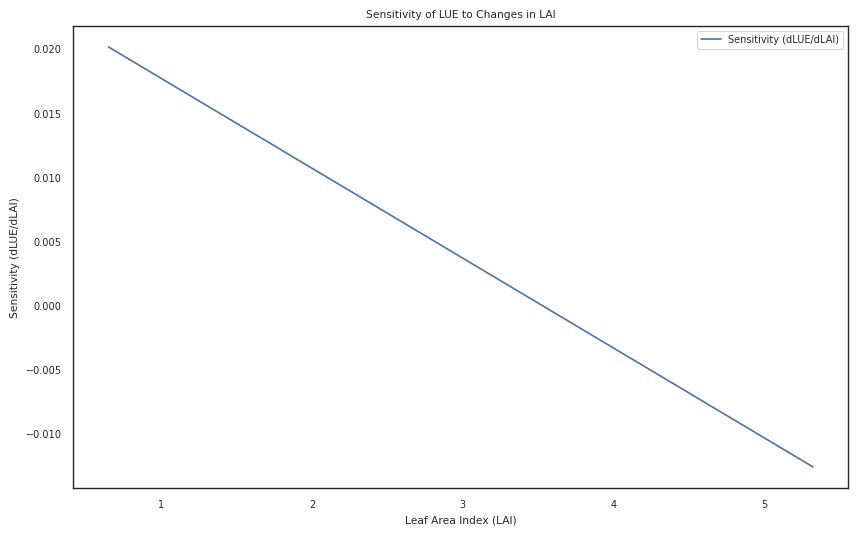

In [351]:
# Derivative of the polynomial (sensitivity)
sensitivity = np.polyder(polynomial)

# Calculate sensitivity values
sensitivity_values = sensitivity(lai_fit)

plt.figure(figsize=(10, 6))
plt.plot(lai_fit, sensitivity_values, "-", label="Sensitivity (dLUE/dLAI)")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Sensitivity (dLUE/dLAI)")
plt.title("Sensitivity of LUE to Changes in LAI")
plt.legend()
plt.show()

In [374]:
tmp

,fpar,nirv,nirvp,fesc,lue,lai,dlue_dlai,dnirv_dlai
type,,,,,,,,
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500,0.052788,0.425740
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500,0.047695,0.383805
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500,0.028239,0.234464
WSA,0.510000,0.175598,56.961575,0.349729,0.035480,1.6500,0.022225,0.086871
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500,0.006753,-0.068589
WET,0.655000,0.196230,45.559644,0.379135,0.040759,1.8875,0.026475,0.095154
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000,0.006280,-0.024082
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125,0.021270,0.187720
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000,0.010213,0.008717


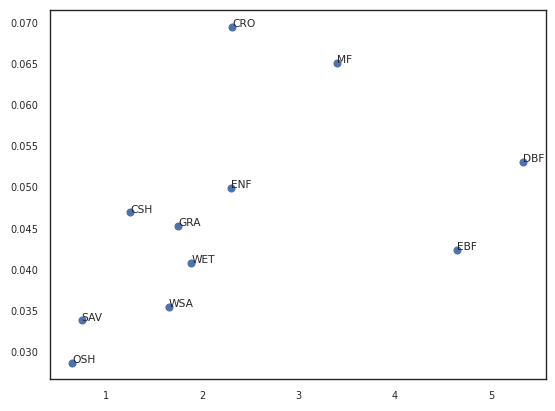

In [392]:
lai_sorted = tmp["lai"].values
lue_sorted = tmp["lue"].values
plant_type_sorted = tmp.index
plt.plot(lai_sorted, lue_sorted, "o")
for i, txt in enumerate(plant_type_sorted):
    plt.annotate(txt, (lai_sorted[i], lue_sorted[i]))

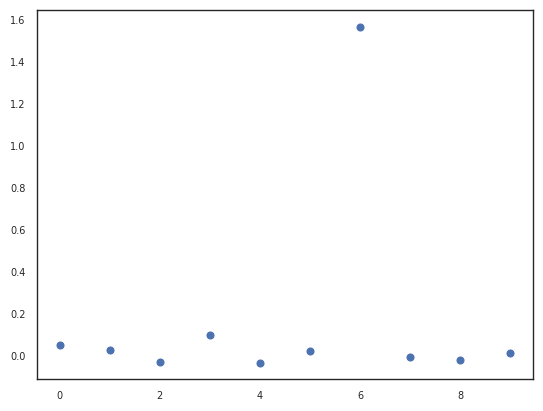

In [391]:
delta_lai_sorted = np.diff(lai_sorted)
delta_lue_sorted = np.diff(lue_sorted)
sensitivity_sorted = delta_lue_sorted / delta_lai_sorted
midpoints_lai_sorted = (lai_sorted[:-1] + lai_sorted[1:]) / 2
plt.plot(sensitivity_sorted, "o")

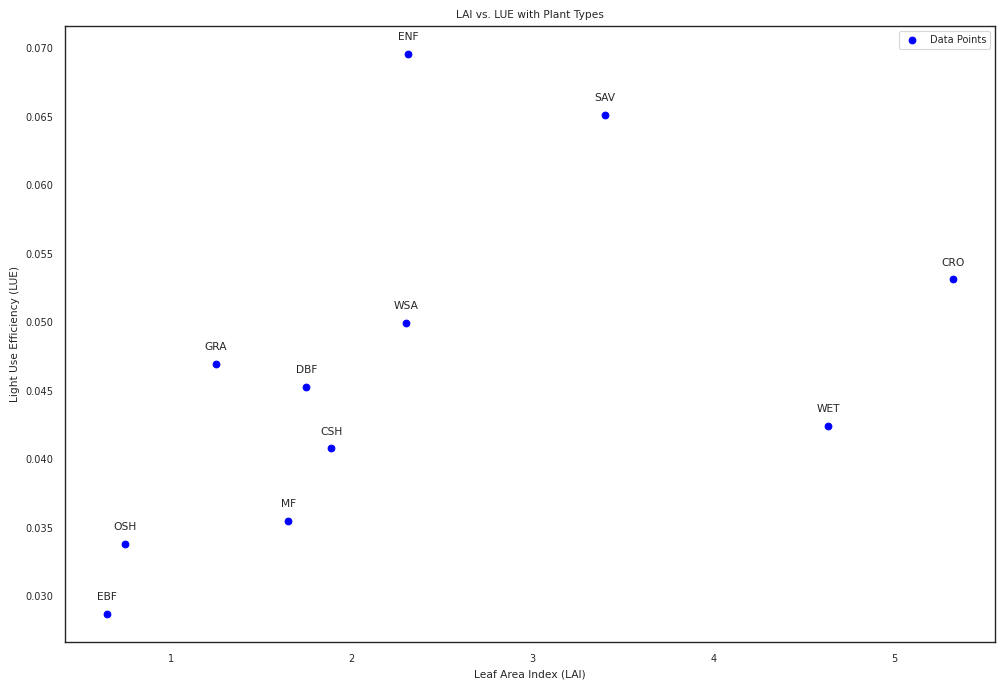

In [388]:
plt.figure(figsize=(12, 8))
plt.scatter(lai_sorted, lue_sorted, c="blue", label="Data Points")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Light Use Efficiency (LUE)")
plt.title("LAI vs. LUE with Plant Types")
plt.legend()

# Annotate points with plant types
for i in range(len(lai_sorted)):
    plt.annotate(
        plant_types_sorted[i],
        (lai_sorted[i], lue_sorted[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

plt.show()

In [385]:
tmp

,fpar,nirv,nirvp,fesc,lue,lai,dlue_dlai,dnirv_dlai
type,,,,,,,,
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500,0.052788,0.425740
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500,0.047695,0.383805
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500,0.028239,0.234464
WSA,0.510000,0.175598,56.961575,0.349729,0.035480,1.6500,0.022225,0.086871
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500,0.006753,-0.068589
WET,0.655000,0.196230,45.559644,0.379135,0.040759,1.8875,0.026475,0.095154
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000,0.006280,-0.024082
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125,0.021270,0.187720
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000,0.010213,0.008717


In [368]:
# Sort data by LAI for consistency
sorted_indices = np.argsort(lai)
lai_sorted = lai[sorted_indices]
lue_sorted = lue[sorted_indices]
plant_types_sorted = types[sorted_indices]

# Compute finite differences for sorted data
delta_lai = np.diff(lai_sorted)
delta_lue = np.diff(lue_sorted)

# Calculate sensitivity (dLUE/dLAI)
sensitivity = delta_lue / delta_lai

# Calculate midpoints for plotting sensitivity
midpoints_lai = (lai_sorted[:-1] + lai_sorted[1:]) / 2
midpoints_plant_types = plant_types_sorted[:-1]

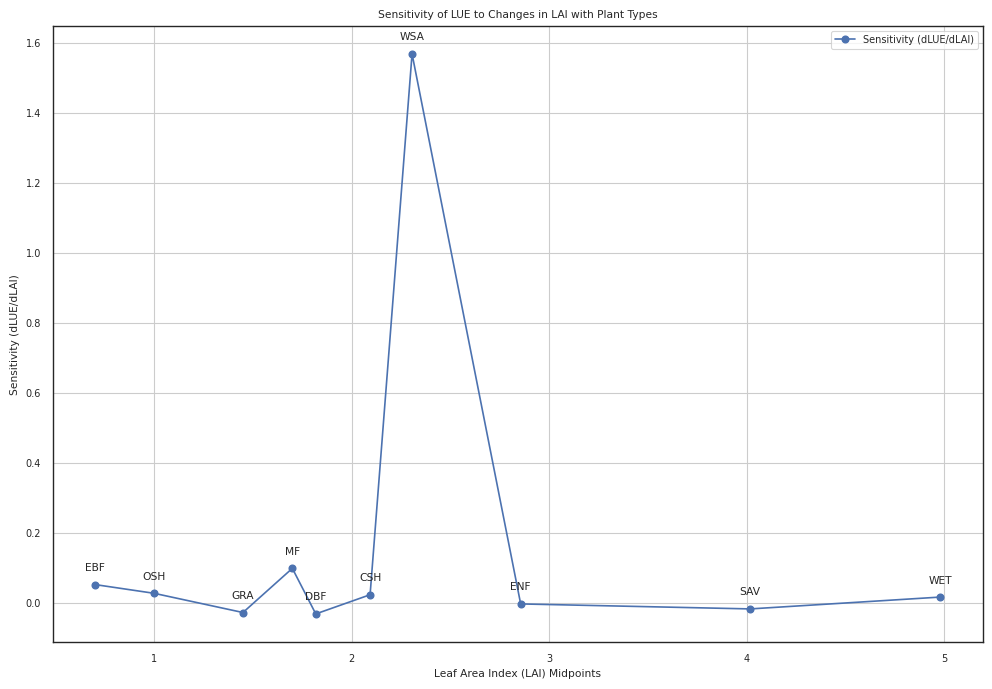

In [369]:
plt.figure(figsize=(12, 8))

# Plot sensitivity
plt.plot(midpoints_lai, sensitivity, "o-", label="Sensitivity (dLUE/dLAI)")

# Annotate each point with plant type
for i, plant_type in enumerate(midpoints_plant_types):
    plt.annotate(
        plant_type,
        (midpoints_lai[i], sensitivity[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
    )

plt.xlabel("Leaf Area Index (LAI) Midpoints")
plt.ylabel("Sensitivity (dLUE/dLAI)")
plt.title("Sensitivity of LUE to Changes in LAI with Plant Types")
plt.legend()
plt.grid(True)
plt.show()

In [360]:
delta_lue / delta_lai

array([ 0.0212696 ,  0.00150909,  0.01553105, -0.00321593,  0.00851405,
        0.01203682,  0.01325303,  0.05135023,  0.00611993,  0.02222467])

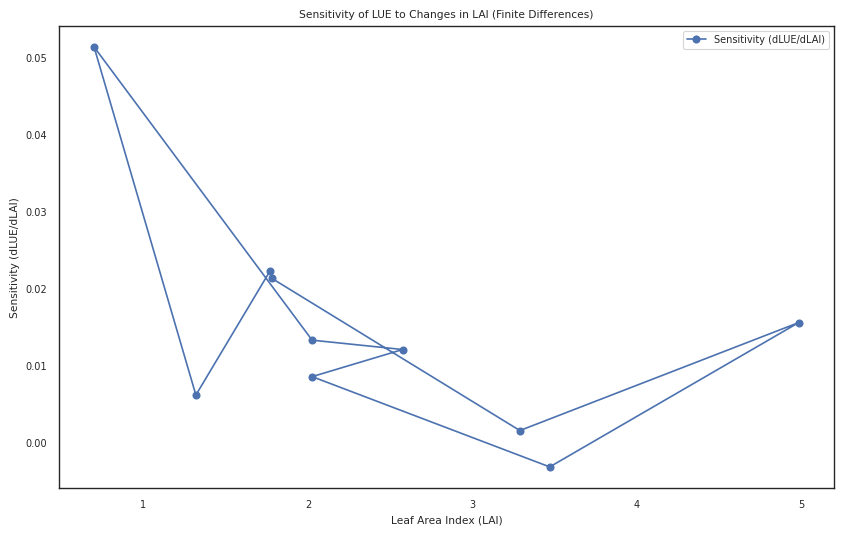

In [353]:
# Compute finite differences for LAI and LUE
delta_lai = np.diff(lai)
delta_lue = np.diff(lue)

# Calculate sensitivity (dLUE/dLAI)
sensitivity = delta_lue / delta_lai

# Calculate midpoints for plotting sensitivity
midpoints_lai = (lai[:-1] + lai[1:]) / 2

plt.figure(figsize=(10, 6))
plt.plot(midpoints_lai, sensitivity, "-o", label="Sensitivity (dLUE/dLAI)")
plt.xlabel("Leaf Area Index (LAI)")
plt.ylabel("Sensitivity (dLUE/dLAI)")
plt.title("Sensitivity of LUE to Changes in LAI (Finite Differences)")
plt.legend()
plt.show()

In [354]:
midpoints_lai

array([1.78125004, 3.2875001 , 4.98125011, 3.46875002, 2.025     ,
       2.57500005, 2.02500005, 0.7       , 1.31875002, 1.76875002])

In [362]:
(1.25 + 5.3) / 2

3.275

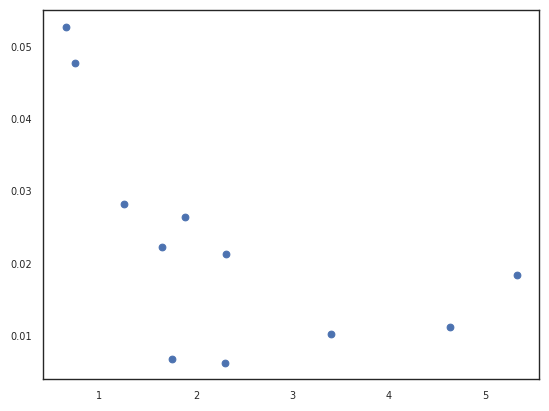

In [330]:
# Sort the DataFrame by 'lai'
# site_annual_max_lue_grouped_mean = site_annual_max_lue_grouped_mean.sort_values(by='lai')

# Extract the sorted values
lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
lai_values = site_annual_max_lue_grouped_mean["lai"].values

# Calculate the derivatives
dlue_dlai = np.gradient(lue_values, lai_values)
dnirv_dlai = np.gradient(nirv_values, lai_values)

# Add the derivatives back to the DataFrame
site_annual_max_lue_grouped_mean["dlue_dlai"] = dlue_dlai
site_annual_max_lue_grouped_mean["dnirv_dlai"] = dnirv_dlai
plt.scatter(
    site_annual_max_lue_grouped_mean["lai"],
    site_annual_max_lue_grouped_mean["dlue_dlai"],
)

In [306]:
# Ensure that 'lai', 'lue', and 'nirv' are sorted in ascending order of 'lai'
site_annual_max_lue = site_annual_max_lue.drop_duplicates(subset="lai")
site_annual_max_lue = site_annual_max_lue.sort_values(by="lai")

# Calculate the derivative of 'lue' with respect to 'lai'
site_annual_max_lue["dlue_dlai"] = np.gradient(
    site_annual_max_lue["lue"], site_annual_max_lue["lai"]
)

# Calculate the derivative of 'nirv' with respect to 'lai'
site_annual_max_lue["dnirv_dlai"] = np.gradient(
    site_annual_max_lue["nirv"], site_annual_max_lue["lai"]
)

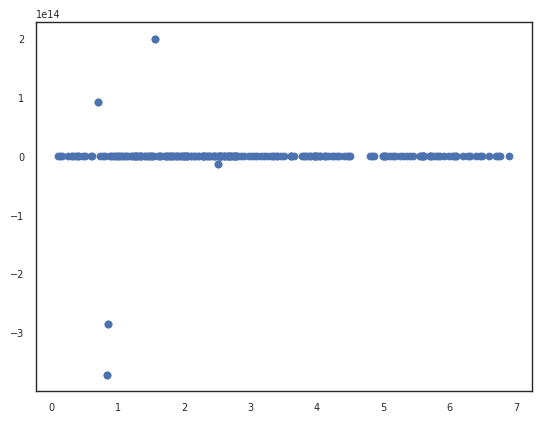

In [308]:
plt.scatter(site_annual_max_lue["lai"], site_annual_max_lue["dlue_dlai"])

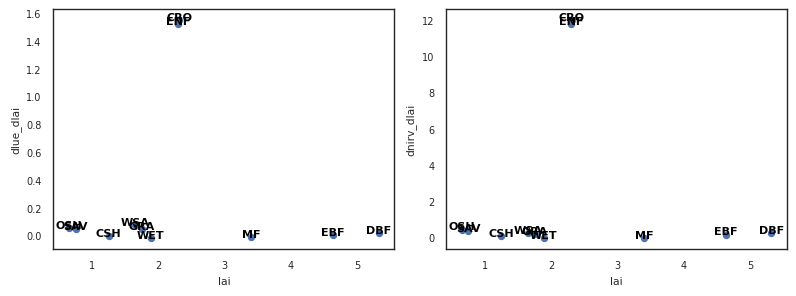

In [311]:
import matplotlib.pyplot as plt

lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
lai_values = site_annual_max_lue_grouped_mean["lai"].values

# Calculate the derivatives
dlue_dlai = np.gradient(lue_values, lai_values)
dnirv_dlai = np.gradient(nirv_values, lai_values)

# Add the derivatives back to the DataFrame
site_annual_max_lue_grouped_mean["dlue_dlai"] = dlue_dlai
site_annual_max_lue_grouped_mean["dnirv_dlai"] = dnirv_dlai

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="lai", y="dlue_dlai", kind="scatter", ax=axs[0])

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[0].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Plot the 'dnirv_dlai' derivative
site_annual_max_lue_grouped_mean.plot(
    x="lai", y="dnirv_dlai", kind="scatter", ax=axs[1]
)
# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[1].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

plt.tight_layout()
plt.show()

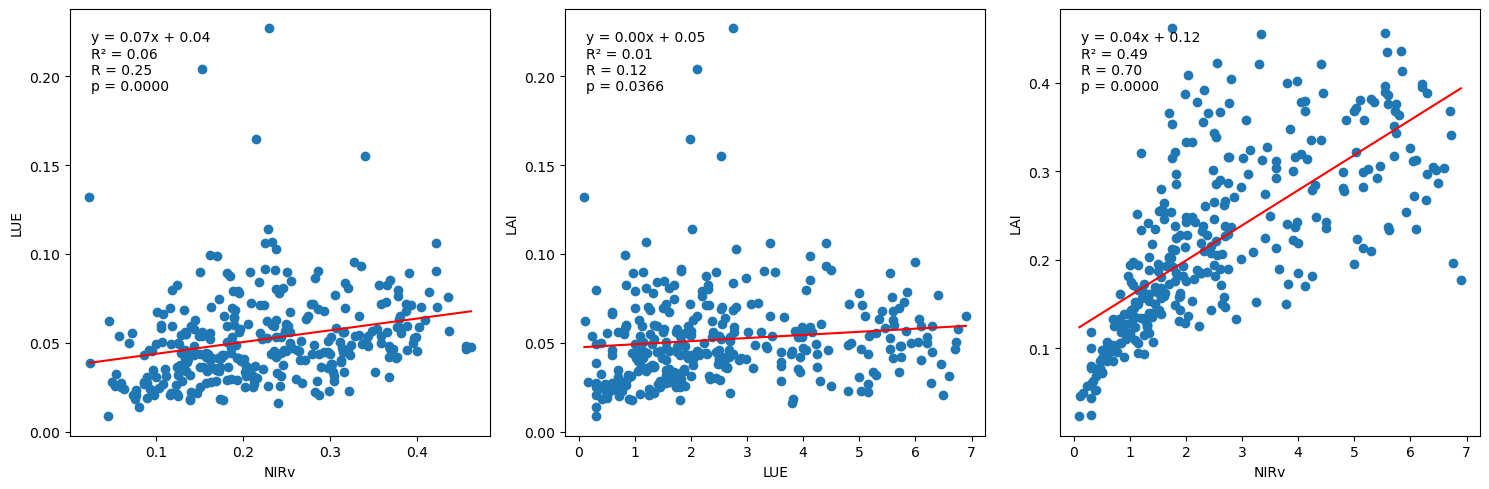

In [189]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))


def plot_linear_fit(x, y, ax):
    model = LinearRegression().fit(x[:, np.newaxis], y)
    x_range = np.linspace(x.min(), x.max(), 100)
    y_pred = model.predict(x_range[:, np.newaxis])
    ax.plot(x_range, y_pred, color="red")
    r, p = stats.pearsonr(x, y)
    ax.text(
        0.05,
        0.95,
        f"y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}\nR² = {r2_score(y, model.predict(x[:, np.newaxis])):.2f}\nR = {r:.2f}\np = {p:.4f}",
        transform=ax.transAxes,
        va="top",
    )


ax1.scatter(site_annual_max_lue["nirv"], site_annual_max_lue["lue"])
plot_linear_fit(
    site_annual_max_lue["nirv"].values, site_annual_max_lue["lue"].values, ax1
)
ax1.set_xlabel("NIRv")
ax1.set_ylabel("LUE")

# Plot lue vs lai
ax2.scatter(site_annual_max_lue["lai"], site_annual_max_lue["lue"])
plot_linear_fit(
    site_annual_max_lue["lai"].values, site_annual_max_lue["lue"].values, ax2
)
ax2.set_xlabel("LUE")
ax2.set_ylabel("LAI")

# Plot nirv vs lai
ax3.scatter(site_annual_max_lue["lai"], site_annual_max_lue["nirv"])
plot_linear_fit(
    site_annual_max_lue["lai"].values, site_annual_max_lue["nirv"].values, ax3
)
ax3.set_xlabel("NIRv")
ax3.set_ylabel("LAI")

plt.tight_layout()
plt.show()

R: 0.2537137675412926
R^2: 0.06437067583999706


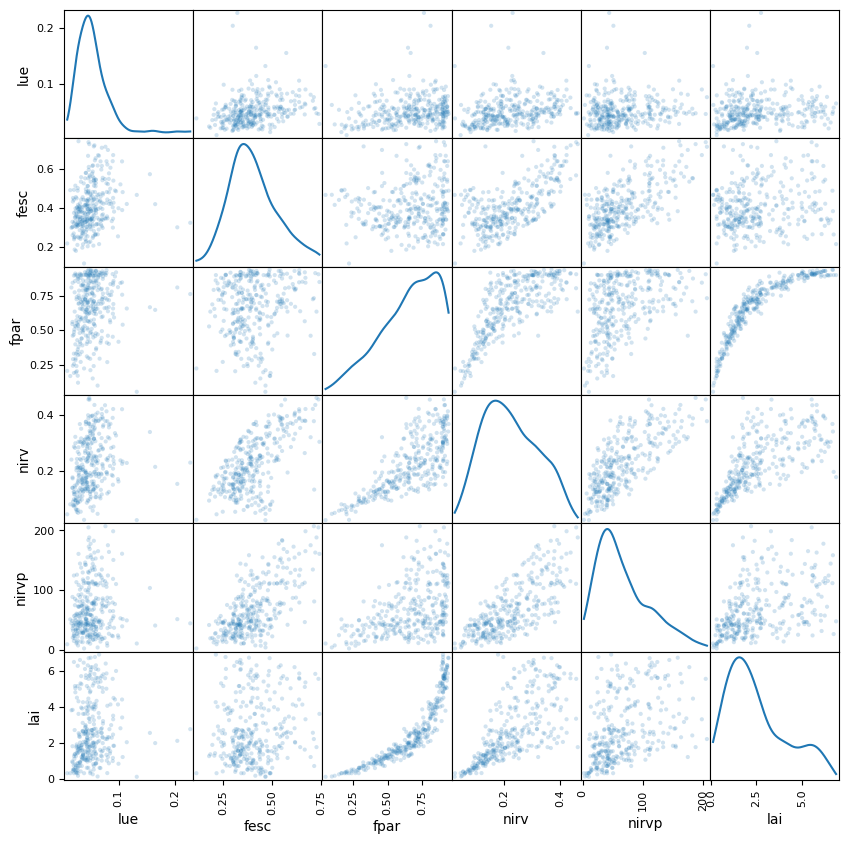

In [181]:
from sklearn.linear_model import LinearRegression

pd.plotting.scatter_matrix(
    site_annual_max_lue[["lue", "fesc", "fpar", "nirv", "nirvp", "lai"]],
    alpha=0.2,
    figsize=(10, 10),
    diagonal="kde",
)
# Create a linear regression model
model = LinearRegression()

# Fit the model using "fesc" as the independent variable and "lue" as the dependent variable
model.fit(site_annual_max_lue[["lue"]], site_annual_max_lue[["nirv"]])

# Calculate the R score
# r_score = model.score(site_annual_max_lue[["lue"]], site_annual_max_lue[["fesc"]])
# print("R score:", r_score)
r = np.corrcoef(site_annual_max_lue["lue"], site_annual_max_lue["nirv"])[0, 1]
print("R:", r)

r_squared = r**2
print("R^2:", r_squared)

In [29]:
site_annual_max_lue = site_annual_max_lue[site_annual_max_lue["fesc"] <= 1]
site_annual_max_lue_se = site_annual_max_lue_se[
    site_annual_max_lue_se.index.isin(site_annual_max_lue.index)
]
site_annual_max_lue_grouped_mean = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai"]]
    .groupby("type")
    .median()
)
site_annual_max_lue_grouped_std = (
    site_annual_max_lue[["fpar", "nirv", "nirvp", "fesc", "lue", "type", "lai"]]
    .groupby("type")
    .std()
)
n = site_annual_max_lue.groupby("type").size()
site_annual_max_lue_grouped_se = site_annual_max_lue_grouped_std.div(np.sqrt(n), axis=0)

In [35]:
# site_annual_max_lue_grouped_mean = site_annual_max_lue_grouped_mean.drop(
#     ["DBF_low", "SAV_low", "EBF_mid"], errors="ignore"
# )

In [80]:
site_annual_max_lue_grouped_mean

,fpar,nirv,nirvp,fesc,lue,lai
type,,,,,,
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500
DBF,0.901250,0.362982,98.551784,0.506816,0.053090,5.3250
EBF,0.868125,0.201026,46.852877,0.320755,0.042413,4.6375
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500


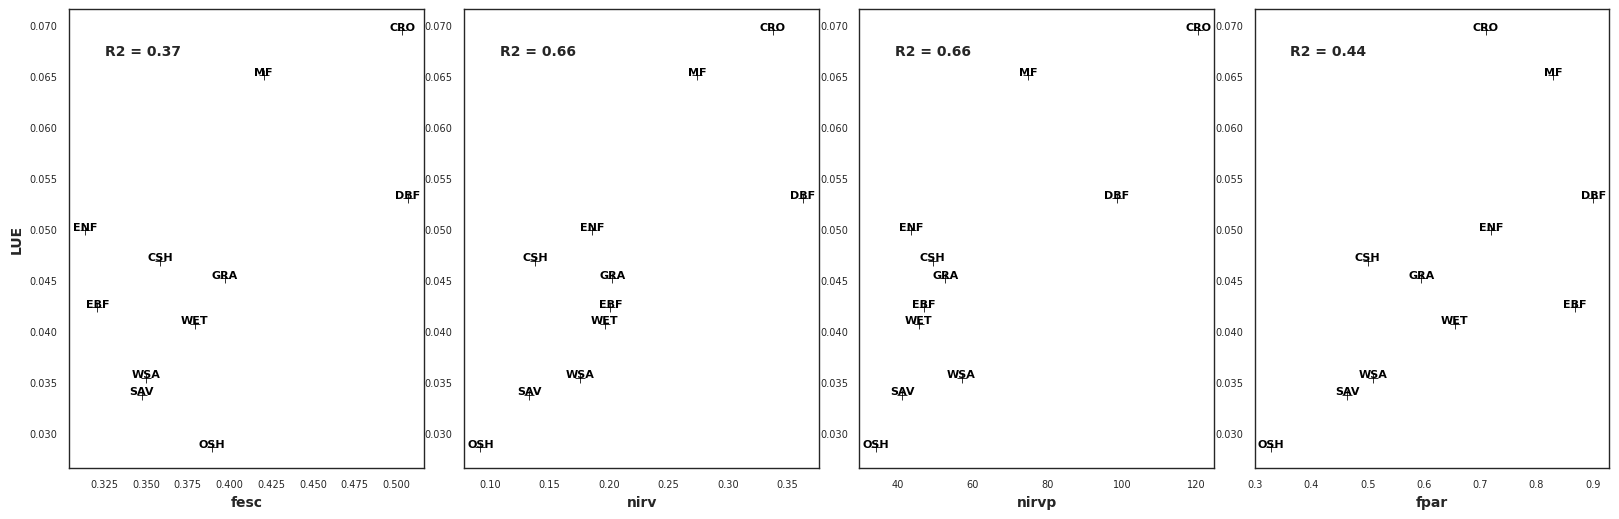

In [288]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("LUE", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
# print(results_df)

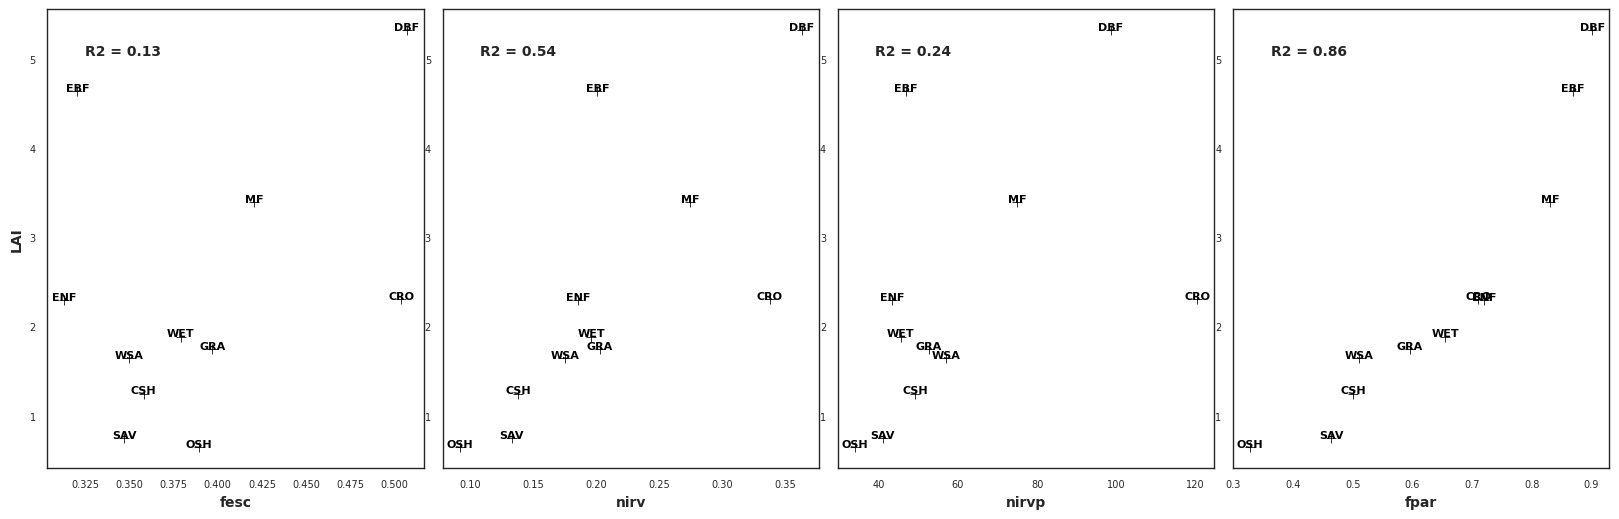

In [289]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lai"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("LAI", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)
# Display the DataFrame with results
# print(results_df)

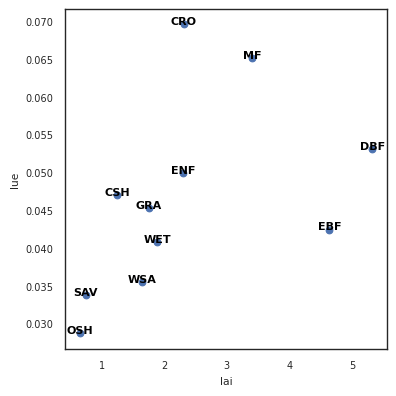

In [290]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
plt.figure(figsize=(4, 4))
# host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# Plot 'lai' vs 'lue'
plt.scatter(df_to_plot["lai"], df_to_plot["lue"])

# Add labels next to the points
for line in range(df_to_plot.shape[0]):
    plt.text(
        df_to_plot["lai"].iloc[line],
        df_to_plot["lue"].iloc[line],
        df_to_plot.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Add labels to the axes
plt.xlabel("lai")
plt.ylabel("lue")

plt.tight_layout()
plt.show()

In [ ]:
site_annual_max_lue_grouped_mean["ci_lai"] = (
    site_annual_max_lue_grouped_mean["ci"] * site_annual_max_lue_grouped_mean["lai"]
)

In [293]:
site_annual_max_lue_grouped_mean

,fpar,nirv,nirvp,fesc,lue,lai,dlue_dlai,dnirv_dlai
type,,,,,,,,
CRO,0.710000,0.337544,120.418823,0.503605,0.069540,2.3125,0.021270,0.187720
CSH,0.500000,0.138092,49.214404,0.358201,0.046941,1.2500,0.028239,0.234464
DBF,0.901250,0.362982,98.551784,0.506816,0.053090,5.3250,0.018377,0.272183
EBF,0.868125,0.201026,46.852877,0.320755,0.042413,4.6375,0.011270,0.183541
ENF,0.720000,0.185522,43.387824,0.313459,0.049930,2.3000,0.006280,-0.024082
GRA,0.595000,0.202742,52.664821,0.396978,0.045247,1.7500,0.006753,-0.068589
MF,0.830000,0.274106,74.913595,0.420424,0.065108,3.4000,0.010213,0.008717
OSH,0.327500,0.091854,33.926487,0.389519,0.028662,0.6500,0.052788,0.425740
SAV,0.463750,0.133121,41.033376,0.347241,0.033797,0.7500,0.047695,0.383805


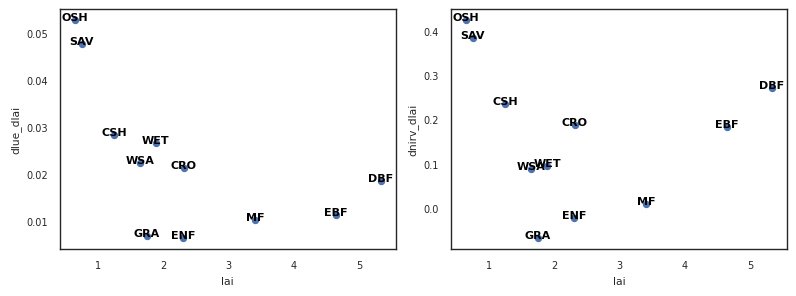

In [292]:
import matplotlib.pyplot as plt

lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
lai_values = site_annual_max_lue_grouped_mean["lai"].values

# Calculate the derivatives
dlue_dlai = np.gradient(lue_values, lai_values)
dnirv_dlai = np.gradient(nirv_values, lai_values)

# Add the derivatives back to the DataFrame
site_annual_max_lue_grouped_mean["dlue_dlai"] = dlue_dlai
site_annual_max_lue_grouped_mean["dnirv_dlai"] = dnirv_dlai

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Plot the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="lai", y="dlue_dlai", kind="scatter", ax=axs[0])

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[0].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Plot the 'dnirv_dlai' derivative
site_annual_max_lue_grouped_mean.plot(
    x="lai", y="dnirv_dlai", kind="scatter", ax=axs[1]
)
# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    axs[1].text(
        site_annual_max_lue_grouped_mean["lai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

plt.tight_layout()
plt.show()

In [ ]:
# Calculate the R-squared value
# r2_linear = model.score(site_annual_max_lue_grouped_mean[['dlue_dlai']], site_annual_max_lue_grouped_mean[['dnirv_dlai']])

# Create a new figure
plt.figure(figsize=(6, 6))

# Plot the 'dnirv_dlai' derivative against the 'dlue_dlai' derivative
site_annual_max_lue_grouped_mean.plot(x="dlue_dlai", y="dnirv_dlai", kind="scatter")

# Add labels next to the points
for line in range(site_annual_max_lue_grouped_mean.shape[0]):
    plt.text(
        site_annual_max_lue_grouped_mean["dlue_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean["dnirv_dlai"].iloc[line],
        site_annual_max_lue_grouped_mean.index[line],
        horizontalalignment="center",
        size=8,
        color="black",
        weight="semibold",
    )

# Add the R-squared value to the plot
# plt.text(0.05, 0.95, f'R² = {r2_linear:.2f}', ha='left', va='top', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [ ]:
zi

In [ ]:
lue_values = site_annual_max_lue_grouped_mean["lue"].values
nirv_values = site_annual_max_lue_grouped_mean["nirv"].values
ci_lai_values = site_annual_max_lue_grouped_mean["ci_lai"].values

# Calculate the derivatives
dlue_dci_lai = np.gradient(lue_values, ci_lai_values)
dnirv_dci_lai = np.gradient(nirv_values, ci_lai_values)

In [ ]:
plt.plot(ci_lai_values, dlue_dci_lai, "*")

In [ ]:
plt.plot(ci_lai_values, dnirv_dci_lai, "*")

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(16, 5))
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
# variables = ["fesc","fesc_n", "fpar","fesc_p"]
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "struct"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=[
        "Variable",
        "Linear_Slope",
        "Linear_Intercept",
        "Linear_R_squared",
        "NonLinear_Coefficients",
        "NonLinear_R_squared",
    ]
)

for i, x in enumerate(variables):
    # Fit the linear model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2_linear = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r_linear = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    # Store results in the DataFrame
    # results_df.loc[i] = [
    #     x,
    #     model.coef_[0][0],
    #     model.intercept_[0],
    #     r2_linear,
    #     # popt,
    #     # r2_nonlinear,
    # ]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            # df_to_plot[x].iloc[line] + 0.01,
            # df_to_plot[y].iloc[line] + 0.001,
            df_to_plot[x].iloc[line],
            df_to_plot[y].iloc[line],
            df_to_plot.index[line],
            horizontalalignment="center",
            size=8,
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        # f"Linear R² = {r2_linear:.2f}\nNon-linear R² = {r2_nonlinear:.2f}",
        f"R2 = {r2_linear:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")
    if i == 0:
        host[i].set_ylabel("structure", fontsize=10, fontweight="bold")

plt.tight_layout(pad=0.01)


# Display the DataFrame with results
# print(results_df)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="lue", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
plt.ylim(0, 0.18)
ax.grid(color="gray", linestyle="-", alpha=0.3)
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_lue_box.png")

In [ ]:
cite = pd.read_csv("../data/citations_for_site_data_Ameriflux.csv", skiprows=5)
cite.rename(columns={"site_id": "name"}, inplace=True)

# Initialize an empty DataFrame to store the results
data_cite = []

for name in names:
    site_name = name
    site_type = df[df["name"] == name]["type"].values[0]
    t1 = df[df["name"] == name].index[0]
    t2 = df[df["name"] == name].index[-1]
    date_range = str(t1.date()) + " - " + str(t2.date())
    site_cite = cite[cite["name"] == name]

    if len(site_cite) == 0:
        doi_url = "FLUXNET2015"
        data_cite.append(
            {
                "Name": site_name,
                "Type": site_type,
                "Date Range": date_range,
                "URL": doi_url,
            }
        )
        continue
    doi_url = site_cite["doi_url"].values[0]
    data_cite.append(
        {
            "Name": site_name,
            "Type": site_type,
            "Date Range": date_range,
            "URL": doi_url,
        }
    )
data_cite = pd.DataFrame(data_cite)
data_cite.to_csv("../outputs/data_cite.csv", index=False)

In [ ]:
results = []
for type in types:
    df_type = df[df["type"] == type]
    number_of_sites = len(df_type["name"].unique())
    number_of_obs = len(df_type)
    results.append(
        {
            "Type": type,
            "Number of Sites": number_of_sites,
            "Number of Observations": number_of_obs,
        }
    )
results = pd.DataFrame(results)
results.to_csv("../outputs/data_summary.csv", index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Create the boxplots
site_annual_max_lue.boxplot(column="fesc", by="type", widths=0.6, ax=ax)
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.tick_params(axis="x", labelsize=14, labelrotation=45)
plt.tick_params(axis="y", labelsize=14)
ax.grid(color="gray", linestyle="-", alpha=0.3)
ax.xaxis.label.set_weight("bold")
fig.suptitle("")

# for tick in ax.get_xticklabels():
#     tick.set_fontweight('bold')
# for tick in ax.get_yticklabels():
#     tick.set_fontweight('bold')

plt.tight_layout()
plt.savefig("../outputs/figures/annual_max_fesc_box.png")

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(
    style="white", context="paper", font_scale=0.8
)  # Changed style to "white" to remove grids

# Create a 1x4 grid of subplots
fig, host = plt.subplots(1, 4, figsize=(10, 2.5))  # Adjusted figure size
host = host.flatten()

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=["Variable", "Slope", "Intercept", "R_squared"])

for i, x in enumerate(variables):
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Store slope, intercept, and R² in the DataFrame
    results_df.loc[i] = [x, model.coef_[0][0], model.intercept_[0], r2]

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host[i],
        color="black",
        legend=False,
        s=50,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.01,
            df_to_plot[y].iloc[line] + 0.001,
            df_to_plot.index[line],
            horizontalalignment="center",
            size="small",
            color="black",
            weight="semibold",
        )

    # Add R² to the plot
    host[i].text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host[i].transAxes,
        fontsize=10,
        fontweight="bold",
    )  # Reduced font size

    # Set labels and title
    host[i].set_xlabel(x, fontsize=10, fontweight="bold")
    host[i].set_ylabel("")  # Removing y-label
    if i == 0:
        host[i].set_ylabel(
            "LUE", fontsize=10, fontweight="bold"
        )  # Added y-label to the first subplot

plt.tight_layout(pad=0.01)  # Adjust subplot parameters to give specified padding
plt.savefig("../outputs/figures/between_pft_scatter.png", dpi=300, bbox_inches="tight")

# Display the DataFrame with results
print(results_df)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Set a style and context for seaborn
sns.set(style="white", context="paper", font_scale=0.8)

# Load your data for site_annual_max_grouped_mean and site_annual_max_grouped_std
# Assuming these are already defined in your environment

df_to_plot = site_annual_max_lue_grouped_mean
variables = ["fesc", "nirv", "nirvp", "fpar"]
y = "lue"

for x in variables:
    # Create a single subplot with custom size
    fig, host = plt.subplots(1, 1, figsize=(3.5, 3.8))
    # Fit the model and calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])

    # Create scatterplot
    scatter = sns.scatterplot(
        data=df_to_plot,
        x=x,
        y=y,
        marker="+",
        # hue="type",
        ax=host,
        color="black",
        legend=False,
        s=50,
    )
    plt.errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_lue_grouped_se[x],
        yerr=site_annual_max_lue_grouped_se[y],
        fmt="none",
        color="black",
        alpha=0.25,
    )

    # Add text to each point on the scatterplot
    for line in range(df_to_plot.shape[0]):
        scatter.text(
            df_to_plot[x].iloc[line] + 0.002,
            df_to_plot[y].iloc[line] + 0.0005,
            df_to_plot.index[line],
            horizontalalignment="center",
            size=12,
            color="black",
            # weight="semibold",
        )

    # Add R² to the plot
    host.text(
        0.1,
        0.9,
        f"R² = {r2:.2f}",
        transform=host.transAxes,
        fontsize=12,
        fontweight="bold",
    )

    # Set labels and title
    host.set_xlabel("")
    host.set_ylabel("")
    host.set_ylabel("")
    host.tick_params(axis="x", labelsize=12)
    host.tick_params(axis="y", labelsize=12)

    # Save the figure with x and y variables replaced in the filename
    plt.tight_layout(pad=0.01)
    plt.savefig(
        f"../outputs/figures/between_pft_{x}_{y}.png", dpi=300, bbox_inches="tight"
    )
    plt.clf()  # Clear the figure for the next iteration

# Close the figure
plt.close()

In [ ]:
site_annual_max_lue["type"].unique()

In [ ]:
types = site_annual_max_lue["type"].unique()

fig, axs = plt.subplots(3, 4, figsize=(10, 10))  # Reduced figure size to fit A4 paper
axs = axs.flatten()

for i, type in enumerate(types):
    print(type)
    x = "fesc"
    y = "lue"
    site_annual_max_type = site_annual_max_lue[site_annual_max_lue["type"] == type]
    site_annual_max_se_type = site_annual_max_lue_se[
        site_annual_max_lue_se["type"] == type
    ]
    df_to_plot = site_annual_max_type
    axs[i].scatter(
        df_to_plot[x], df_to_plot[y], color="black", marker="+", s=50
    )  # Added color, alpha, and edgecolor for better visualization
    axs[i].set_title(f"{type}", fontsize=12)  # Adjusted font size
    axs[i].set_xlabel(x, fontsize=12)  # Adjusted font size
    axs[i].set_ylabel("LUE$_{\mathrm{Max}}$", fontsize=12)

    axs[i].errorbar(
        df_to_plot[x],
        df_to_plot[y],
        xerr=site_annual_max_se_type[x],
        yerr=site_annual_max_se_type[y],
        fmt="none",
        color="black",
        alpha=0.3,
    )

    # Calculate R²
    model = LinearRegression().fit(df_to_plot[[x]], df_to_plot[[y]])
    r2 = model.score(df_to_plot[[x]], df_to_plot[[y]])
    r = np.corrcoef(df_to_plot[x], df_to_plot[y])[0, 1]

    axs[i].text(
        0.1, 0.9, f"R² = {r:.2f}", transform=axs[i].transAxes, fontsize=12
    )  # Add R² to the plot
    axs[i].tick_params(axis="both", labelsize=8)  # Adjusted font size

# Remove the extra subplots
for j in range(len(types), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
# plt.savefig(
#     "../outputs/figures/within_pft_fesc_lue.png", dpi=300, bbox_inches="tight"
# )  # Adjusted file name and dpi

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

variables = ["fesc"]  # Variables to loop over
y = "lue"
site_r2 = {var: [] for var in variables}  # Initialize a dictionary to store R² values
site_types = []  # Initialize a list to store the types

for name in names:
    tmp_df = df[df["name"] == name]
    site_types.append(tmp_df["type"].iloc[0])  # Append the type of the site
    for x in variables:
        model = LinearRegression().fit(tmp_df[[x]], tmp_df[[y]])
        r2 = model.score(tmp_df[[x]], tmp_df[[y]])
        site_r2[x].append(r2)  # Append R² to the corresponding list in the dictionary

# Convert the dictionary to a pandas DataFrame
r2_df = pd.DataFrame(site_r2, index=names)
r2_df["type"] = site_types  # Add the types as a new column

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

name = names[1]
tmp_df = df[df["name"] == name]
x = "lue"
y = "apar"
# Melt the DataFrame to have a long format
r2_df_melted = r2_df.melt(id_vars="type", var_name="variable", value_name="r2")

# Remove 'SNO' and 'CVM' types
r2_df_melted = r2_df_melted[~r2_df_melted["type"].isin(["SNO", "CVM"])]

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(
    x="type", y="r2", hue="variable", data=r2_df_melted, color="white"
)
# plt.title("R² for different variables by type")

# Change legend labels
new_labels = [f"{var} vs LUE" for var in r2_df.columns if var != "type"]
for t, l in zip(box_plot.legend_.texts, new_labels):
    t.set_text(l)
# Add horizontal line
plt.axhline(y=0.5, color="red", linestyle="--", c="gray")

# Remove legend title
box_plot.legend_.set_title(None)
box_plot.legend_.remove()
box_plot.set_xlabel("")
box_plot.set_ylabel(r"$R^2$", fontsize=14)
box_plot.tick_params(axis="x", labelsize=12)
box_plot.tick_params(axis="y", labelsize=12)
plt.savefig(
    "../outputs/figures/within_sites_r2_fesc_lue.png", dpi=300, bbox_inches="tight"
)